# Read Data

In [3]:
#read in data
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az
import os 





def read_data_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_array(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_array(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_array(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_array(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_array(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_array(traj):
    return np.array(traj)



In [4]:
positions, currents, gyro, accel, angles = read_data_json('data/TrajectoriesTorso.json')

In [5]:
#create a data frame with all the data with one column for each element of the arrays in positions, currents, gyro, accel
def create_df(positions, currents, gyro, accel):
    df = pd.DataFrame()
    for key in positions.keys():
        temp_df = pd.DataFrame({
            'UniqueID': key,
            'TiltPosition': positions[key][:, 0],
            'PanPosition': positions[key][:, 1],
            'TiltCurrent': currents[key][:, 0],
            'PanCurrent': currents[key][:, 1],
            'GyroX': gyro[key][:, 0],
            'GyroY': gyro[key][:, 1],
            'GyroZ': gyro[key][:, 2],
            'AccelX': accel[key][:, 0],
            'AccelY': accel[key][:, 1],
            'AccelZ': accel[key][:, 2]
        })
        df = pd.concat([df, temp_df], ignore_index=True)
    return df

df_all_predictors = create_df(positions, currents, gyro, accel)

#standardize the data
def standardize_data(df):
    df = df.copy()
    for col in df.columns:
        if col != 'UniqueID':
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

df_all_predictors_standardized = standardize_data(df_all_predictors)


In [6]:
df_all_predictors_standardized.head()

UniqueID  TiltPosition  PanPosition  TiltCurrent  PanCurrent     GyroX  \
0    699873     -0.315824     0.024276    -0.065302    0.287871 -0.027395   
1    699873     -0.315824     0.024276    -0.065302    0.287871  0.011748   
2    699873     -0.315824     0.024276    -0.116564   -0.172251  0.015763   
3    699873     -0.313981     0.024276    -0.123887   -0.237983 -0.091629   
4    699873     -0.315824     0.024276    -0.123887   -0.237983 -0.027395   

      GyroY     GyroZ    AccelX    AccelY    AccelZ  
0 -0.032445 -0.020137  0.049532  0.086510  2.871986  
1 -0.027824  0.006174  0.405296 -0.009269 -1.550525  
2 -0.029364  0.045335  0.405296 -0.009269 -1.550525  
3 -0.023202  0.037992  0.405296 -0.009269 -1.550525  
4 -0.062230  0.074706  0.405296 -0.009269 -1.550525

In [7]:
#save data as csv
df_all_predictors_standardized.to_csv('data/trajectories_all_predictors_standardized.csv', index=False)
df_all_predictors.to_csv('data/trajectories_all_predictors.csv', index=False)

In [8]:
#split the data into training and test sets
def split_data(df, train_frac=0.8):
    if "UniqueID" not in df.columns:
        df = df.reset_index(drop=True)
        df['UniqueID'] = df.index
    unique_ids = df['UniqueID'].unique()
    np.random.shuffle(unique_ids)
    train_ids = unique_ids[:int(train_frac * len(unique_ids))]
    test_ids = unique_ids[int(train_frac * len(unique_ids)):]
    train = df[df['UniqueID'].isin(train_ids)]
    test = df[df['UniqueID'].isin(test_ids)]
    return train, test


In [9]:
from collections import defaultdict

# Calculate the average current for specific position and distance to goal
servos = [0, 1]
avg_current_data = {}
for servo in servos:
    current_data = defaultdict(list)
    x, y, z = [], [], []

    for trajectory in currents.keys():
        # Collect data points for starting position and distance to goal
        current_vals = currents[trajectory][:, servo]
        trajectory_vals = positions[trajectory][:, servo]
        goal_pos = trajectory_vals[-1]
        distances_to_goal = np.round(abs(trajectory_vals - goal_pos), 2)

        for pos, dist_to_goal, curr in zip(trajectory_vals, distances_to_goal, current_vals):
            # Convert to int to avoid float precision issues
            pos = int(pos)
            dist_to_goal = int(dist_to_goal)
            current_data[(pos, dist_to_goal)].append(curr)

    servoname = "NeckTilt" if servo == 0 else "NeckPan"
    # Create a DataFrame for each servo
    avg_current_data[servoname] = pd.DataFrame([
        {'Position': pos, 'DistanceToGoal': dist, 'AvgCurrent': np.mean(np.abs(currents))}
        for (pos, dist), currents in current_data.items()
    ])


In [10]:
#normalize and standardize data
std_avg_current_data = {}
for servo, data in avg_current_data.items():
    dat = data.copy()
    dat['Position'] = (dat['Position'] - dat['Position'].mean()) / dat['Position'].std()
    dat['DistanceToGoal'] = (dat['DistanceToGoal'] - dat['DistanceToGoal'].mean()) / dat['DistanceToGoal'].std()
    dat['AvgCurrent'] = (dat['AvgCurrent'] - dat['AvgCurrent'].mean()) / dat['AvgCurrent'].std()
    std_avg_current_data[servo] = dat

# Plot functions

In [60]:
def plot_real_vs_predicted(data, ppc, indep_var='Position'):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    if isinstance(indep_var, list):
        fig, axes = plt.subplots(1, len(indep_var), figsize=(15, 6))
        for i, var in enumerate(indep_var):
            axes[i].scatter(data[var], data['AvgCurrent'], alpha=0.5, label='Real Current')
            axes[i].scatter(data[var], predicted_current_raw, alpha=0.5, label='Predicted Current')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Average Current')
            axes[i].legend()
        plt.suptitle('Real vs Predicted Average Current')
    else:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[indep_var], data['AvgCurrent'], alpha=0.5, label='Real Current')
        plt.scatter(data[indep_var], predicted_current_raw, alpha=0.5, label='Predicted Current')
        plt.xlabel(indep_var)
        plt.ylabel('Average Current')
        plt.title('Real vs Predicted Average Current')
        plt.legend()
    plt.show()

In [61]:
#plot function that plots topographic map in 3d of the real vs predicted values
def plot_3d_real_vs_predicted(data, ppc, dep_var=["AvgCurrent", "AvgCurrent"], indep_var=['Position', 'DistanceToGoal'], model_name=''):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive[dep_var[1]].mean(axis=0)[1]
    dep_mean = dat[dep_var[0]].mean()
    dep_std = dat[dep_var[0]].std()
    predicted_current_raw = predicted_current_mean * dep_std + dep_mean
    
    fig = plt.figure(figsize=(20, 6))
    
    # Real Current subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(dat[indep_var[0]], dat[indep_var[1]], dat[dep_var[0]], alpha=0.5, label='Real Current')
    ax1.set_xlabel(indep_var[0])
    ax1.set_ylabel(indep_var[1])
    ax1.set_zlabel(dep_var[0])
    ax1.set_title('Real data')
    
    # Predicted Current subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(dat[indep_var[0]], dat[indep_var[1]], predicted_current_raw, alpha=0.5, label='Predicted Current', color='orange')
    ax2.set_xlabel(indep_var[0])
    ax2.set_ylabel(indep_var[1])
    ax2.set_zlabel(dep_var[0])
    ax2.set_title('Model Prediciton')
    
    # Set the same axis limits for both subplots
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    

    if model_name:
        fig.suptitle('Real vs Predicted current, Model: ' + model_name)
        plt.savefig(f'plots/3d_plot_{model_name}.png')
    else:
        fig.suptitle('Real vs Predicted current')
        plt.savefig('plots/3d_plot_noName.png')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

# Models on the average current

In [68]:
import pytensor.tensor as pt


def LinearModel(data, predictors, target="AvgCurrent", sigma_prior=1):
    X = data[predictors]
    y = data[target]
    
    n_samples = len(X)
    n_predictors = len(predictors)
    
    with pm.Model(coords={"predictors": predictors}) as model:
        # Create pm.Data for each predictor with explicit shapes
        predictor_vars = {}
        for predictor in predictors:
            predictor_vars[predictor] = pm.Data(predictor, X[predictor], dims="obs_id")
            
        # Use the specific name "AvgCurrent" instead of "target"
        observed = pm.Data("AvgCurrent", y, dims="obs_id")
        
        # Define parameters
        intercept = pm.Normal("intercept", 0, 10)
        sigma = pm.HalfNormal("sigma", sigma_prior)
        betas = pm.Normal("betas", 0, 1, dims="predictors")
        
        # Create design matrix
        X_matrix = np.stack([X[p] for p in predictors], axis=1)
        X_shared = pm.Data("X_matrix", X_matrix)
        
        # Calculate mean
        mu = intercept + pt.dot(X_shared, betas)
        
        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu=10, mu=mu, sigma=sigma, observed=observed)
        
        return model



def QuadraticModel(data, predictors, target="AvgCurrent", sigma_prior=1):
    X = data[predictors]
    y = data[target]
    
    n_samples = len(X)
    n_predictors = len(predictors)
    
    with pm.Model(coords={
        "predictors": predictors,
        "quad_predictors": [f"{p}_squared" for p in predictors]
    }) as model:
        # Create design matrix for both linear and quadratic terms
        X_linear = np.stack([X[p] for p in predictors], axis=1)
        X_quadratic = np.stack([X[p]**2 for p in predictors], axis=1)
        
        # Combine linear and quadratic terms
        X_matrix = np.hstack([X_linear, X_quadratic])
        X_shared = pm.Data("X_matrix", X_matrix)
        
        # Observed target variable
        observed = pm.Data("AvgCurrent", y, dims="obs_id")
        
        # Model parameters - now we need coefficients for both linear and quadratic terms
        intercept = pm.Normal("intercept", 0, 10)
        sigma = pm.HalfNormal("sigma", sigma_prior)
        
        # Separate coefficients for linear and quadratic terms
        betas_linear = pm.Normal("betas_linear", 0, 1, dims="predictors")
        betas_quad = pm.Normal("betas_quad", 0, 1, dims="quad_predictors")
        
        # Combine all coefficients
        betas = pt.concatenate([betas_linear, betas_quad])
        
        # Calculate mean using combined design matrix and coefficients
        mu = intercept + pt.dot(X_shared, betas)
        
        # Define likelihood
        likelihood = pm.StudentT("likelihood", nu = 10, mu=mu, sigma=sigma, observed=observed)
        
        return model

## Tilt

In [33]:
tilt_avg_current_train, tilt_avg_current_test = split_data(std_avg_current_data["NeckTilt"])

In [69]:
tilt_avg_current_model = LinearModel(tilt_avg_current_train, ['Position', 'DistanceToGoal'], 'AvgCurrent', sigma_prior=100)
tilt_avg_current_model_quad = QuadraticModel(tilt_avg_current_train, ['Position', 'DistanceToGoal'], 'AvgCurrent', sigma_prior=100)

with tilt_avg_current_model:
    prior_predictive_tilt = pm.sample_prior_predictive(100)
with tilt_avg_current_model_quad:
    prior_predictive_tilt_quad = pm.sample_prior_predictive(100)

Sampling: [betas, intercept, likelihood, sigma]
Sampling: [betas_linear, betas_quad, intercept, likelihood, sigma]


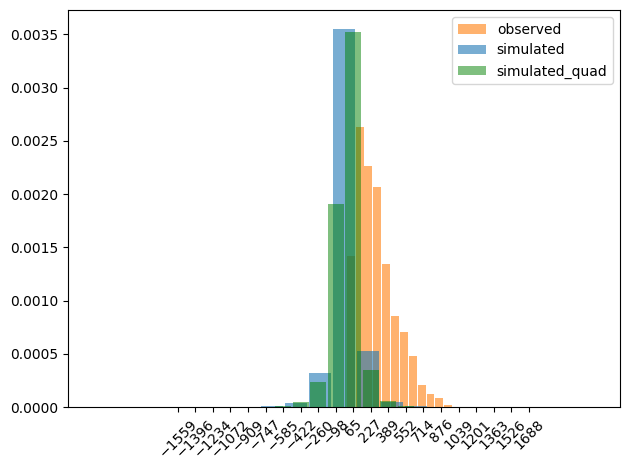

In [70]:
az.plot_dist(
    avg_current_data["NeckTilt"]["AvgCurrent"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_predictive_tilt.prior_predictive["likelihood"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
az.plot_dist(
    prior_predictive_tilt_quad.prior_predictive["likelihood"],
    kind="hist",
    hist_kwargs={"alpha": 0.5},
    label="simulated_quad",
    color="green"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
with tilt_avg_current_model:
    idata_tilt = pm.sample(draws=2000, tune=1000, chains=4, cores=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas]


Output()

Energy change in leapfrog step is too large: 4670829.789172613.
Energy change in leapfrog step is too large: 36366111.86267131.
Energy change in leapfrog step is too large: 1200654609.565716.
Energy change in leapfrog step is too large: 7166594.058742829.
Energy change in leapfrog step is too large: 79376.07018283215.
Energy change in leapfrog step is too large: 817458130.9238843.
Energy change in leapfrog step is too large: 27645277.315537266.
Energy change in leapfrog step is too large: 5465220.364723709.
Energy change in leapfrog step is too large: 145278.61972993467.
Energy change in leapfrog step is too large: 40681.58997350972.
Energy change in leapfrog step is too large: 179983.2325966378.
Energy change in leapfrog step is too large: 1281012325.8127458.
Energy change in leapfrog step is too large: 25051.56223252743.
Energy change in leapfrog step is too large: 6473.799724307147.
Energy change in leapfrog step is too large: 2595.3282258296804.
Energy change in leapfrog step is to

Energy change in leapfrog step is too large: 2643.132252221947.
Energy change in leapfrog step is too large: 2518.631251873896.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [72]:
az.summary(idata_tilt)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept             -0.043  0.009  -0.059   -0.027        0.0      0.0   
betas[Position]       -0.359  0.009  -0.375   -0.341        0.0      0.0   
betas[DistanceToGoal]  0.390  0.009   0.374    0.406        0.0      0.0   
sigma                  0.783  0.007   0.770    0.795        0.0      0.0   

                       ess_bulk  ess_tail  r_hat  
intercept               12912.0    6571.0    1.0  
betas[Position]         12532.0    7238.0    1.0  
betas[DistanceToGoal]   10880.0    6502.0    1.0  
sigma                   12997.0    6594.0    1.0

In [73]:
# When updating with test data:
with tilt_avg_current_model:
    # Create test design matrix
    X_test_matrix = np.stack([tilt_avg_current_test[p] for p in ['Position', 'DistanceToGoal']], axis=1)
    
    # Update all data
    pm.set_data({
        "X_matrix": X_test_matrix,
        "AvgCurrent": tilt_avg_current_test['AvgCurrent']
    })
    
    # Sample posterior predictive
    posterior_pred_tilt = pm.sample_posterior_predictive(idata_tilt)

/home/pierre/ikaros/.venv/lib/python3.12/site-packages/pymc/model/core.py:2140: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('Position'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [likelihood]


Output()

In [74]:
with tilt_avg_current_model_quad:
    idata_tilt_quad = pm.sample(draws=2000, tune=1000, chains=4, cores=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas_linear, betas_quad]


Output()

Energy change in leapfrog step is too large: 1537734018.6733513.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 1068662.408098045.
Energy change in leapfrog step is too large: 77144695.06373523.
Energy change in leapfrog step is too large: inf.


Energy change in leapfrog step is too large: 1137733.9463720014.
Energy change in leapfrog step is too large: 19470808900.862503.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 166731464.59722587.
Energy change in leapfrog step is too large: 55587.87537758453.
Energy change in leapfrog step is too large: 1283578.896926108.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 319985.812084583.
Energy change in leapfrog step is too large: 9119.88693219181.
Energy change in leapfrog step is too large: 12827.220109598733.
Energy change in leapfrog step is too large: 31755.145328266375.
Energy change in leapfrog step is too large: 57319.57058198123.
Energy change in leapfrog step is too large: 1287.6785577376395.
Energy change in leapfrog step is too large: 20989.524022485773.
Energy change in leapfrog step is too large: 43255.471888655404.
Energy change in leapfrog step is too large: 4947.437252698373

Energy change in leapfrog step is too large: 1022.38723351921.
Energy change in leapfrog step is too large: 1621.4927620871276.


Energy change in leapfrog step is too large: 5532.966815093776.


Energy change in leapfrog step is too large: 1626.023670858207.


Energy change in leapfrog step is too large: 1240.7934345294507.
Energy change in leapfrog step is too large: 1669.705344441827.


Energy change in leapfrog step is too large: 1929.6000119275996.


Energy change in leapfrog step is too large: 3152.606563734571.


Energy change in leapfrog step is too large: 1744.5226683348228.


Energy change in leapfrog step is too large: 1106.3947890438485.


Energy change in leapfrog step is too large: 1012.8558772744527.


Energy change in leapfrog step is too large: 3922.6686381070504.


Energy change in leapfrog step is too large: 1088.2513461035578.


Energy change in leapfrog step is too large: 1082.02872261634.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [75]:
az.summary(idata_tilt_quad)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                          -0.694  0.011  -0.714   -0.674        0.0   
betas_linear[Position]             -0.276  0.006  -0.288   -0.264        0.0   
betas_linear[DistanceToGoal]        0.230  0.007   0.217    0.242        0.0   
betas_quad[Position_squared]        0.833  0.009   0.816    0.849        0.0   
betas_quad[DistanceToGoal_squared] -0.134  0.006  -0.146   -0.123        0.0   
sigma                               0.547  0.005   0.538    0.555        0.0   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                               0.0    6741.0    5488.0    1.0  
betas_linear[Position]                  0.0   11080.0    5974.0    1.0  
betas_linear[DistanceToGoal]            0.0    9133.0    5774.0    1.0  
betas_quad[Position_squared]            0.0    7398.0    5636.0    1.0  
betas_quad[DistanceToGoal_squared]      0.0    9759.0    6333.0    1.0  
sigma                                   0.0   11532.0    5896.0    1.0

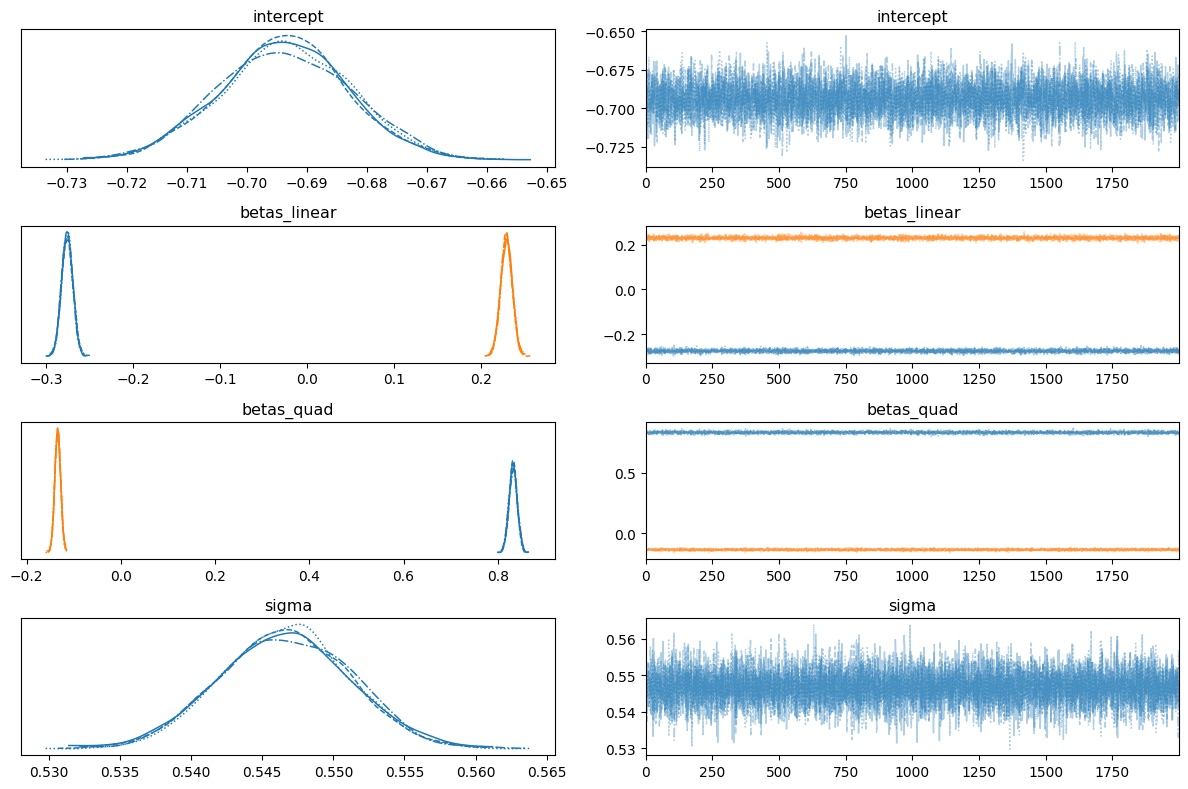

In [77]:
az.plot_trace(idata_tilt_quad)
plt.tight_layout()
plt.show()

In [111]:
predictors = ['Position', 'DistanceToGoal']
with tilt_avg_current_model_quad:
    # Prepare test design matrix
    X_test_linear = np.stack([tilt_avg_current_test[p] for p in predictors], axis=1)
    X_test_quadratic = np.stack([tilt_avg_current_test[p]**2 for p in predictors], axis=1)
    X_test_matrix = np.hstack([X_test_linear, X_test_quadratic])
    
    # Update data
    pm.set_data({
        "X_matrix": X_test_matrix,
        "AvgCurrent": tilt_avg_current_test['AvgCurrent']
    })
    
    # Sample posterior predictive
    posterior_pred_tilt_quad = pm.sample_posterior_predictive(idata_tilt_quad)

Sampling: [likelihood]


Output()

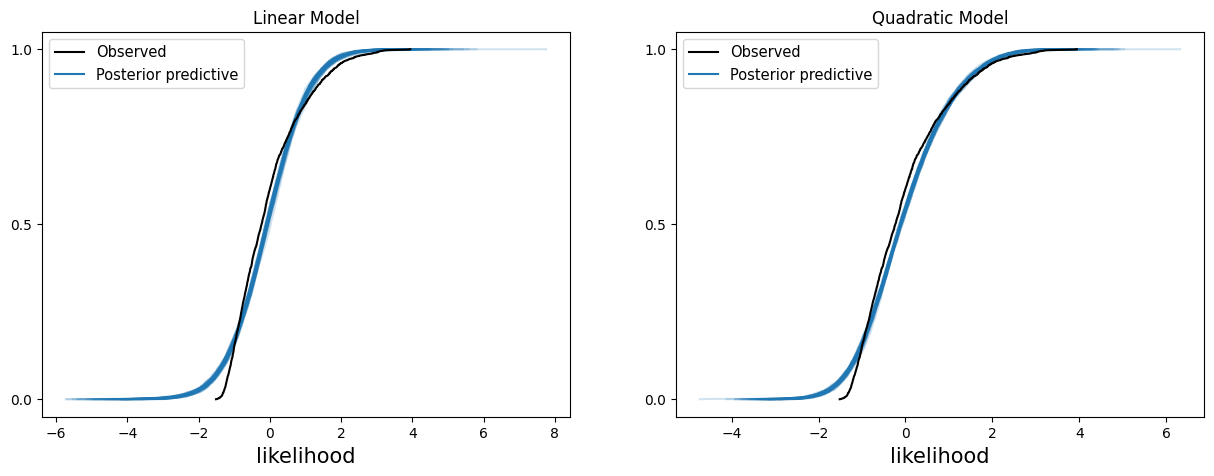

In [83]:
# plot ppc as sub plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
az.plot_ppc(posterior_pred_tilt, ax=axes[0], num_pp_samples=50, mean=False, kind="cumulative")
axes[0].set_title("Linear Model")
az.plot_ppc(posterior_pred_tilt_quad, ax=axes[1], num_pp_samples=50, mean=False, kind="cumulative")
axes[1].set_title("Quadratic Model")
plt.show()

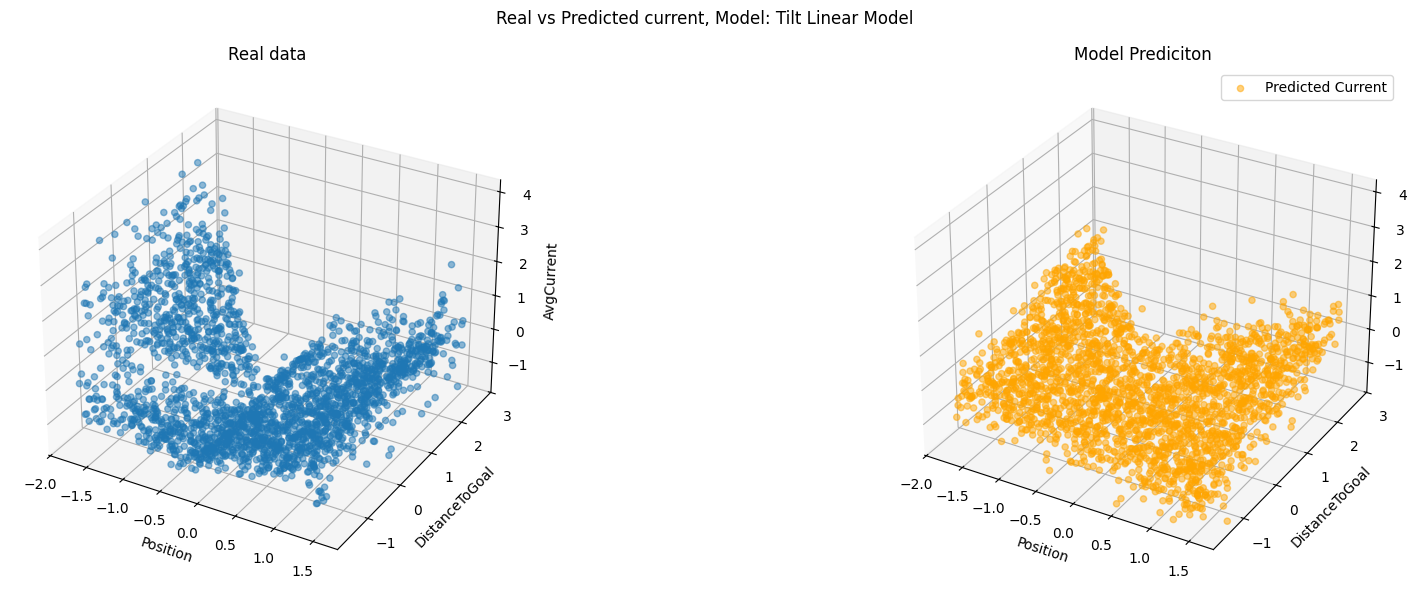

In [108]:
plot_3d_real_vs_predicted(tilt_avg_current_test, posterior_pred_tilt, indep_var=["Position", "DistanceToGoal"], dep_var=["AvgCurrent", "likelihood"], model_name= "Tilt Linear Model")

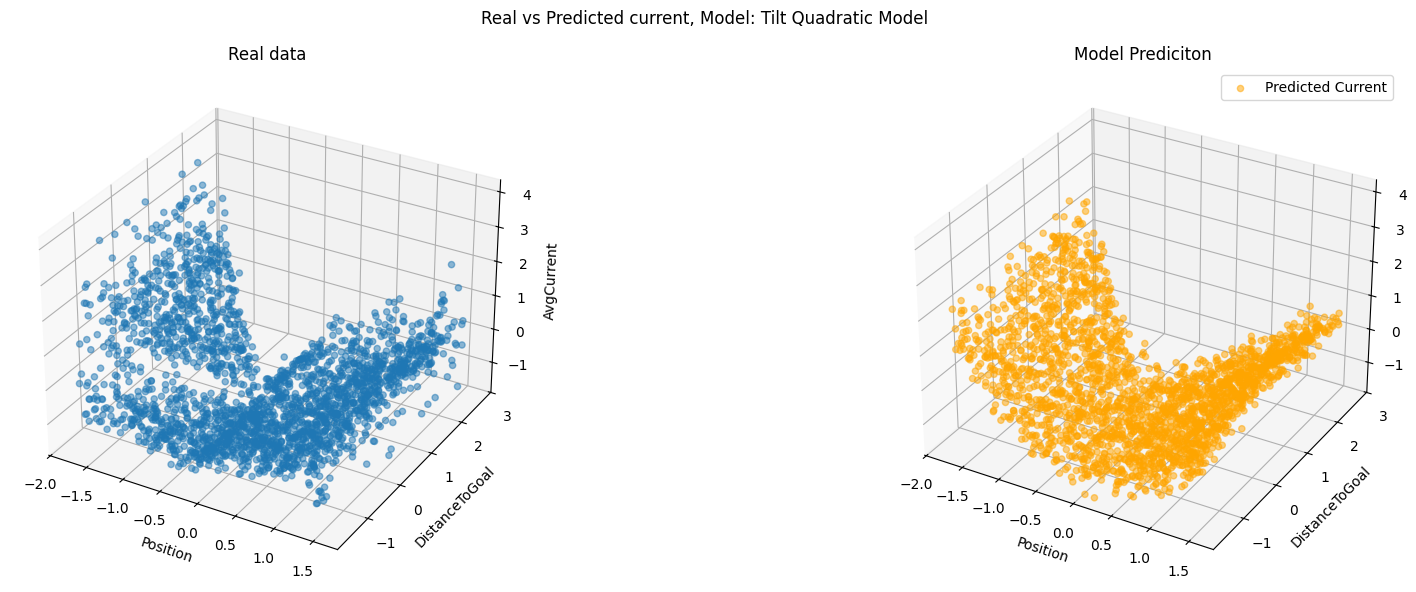

In [112]:
plot_3d_real_vs_predicted(tilt_avg_current_test, posterior_pred_tilt_quad, indep_var=["Position", "DistanceToGoal"], dep_var=["AvgCurrent", "likelihood"], model_name= "Tilt Quadratic Model")

In [87]:
#save the models as nc
idata_tilt.to_netcdf("models/tilt_avg_current_model.nc")
idata_tilt_quad.to_netcdf("models/tilt_avg_current_model_quad.nc")

'models/tilt_avg_current_model_quad.nc'

## Pan

In [ ]:
pan_avg_current_train, pan_avg_current_test = split_data(std_avg_current_data["NeckPan"])


Sampling: [betas, intercept, likelihood, sigma]
Sampling: [betas_linear, betas_quad, intercept, likelihood, sigma]


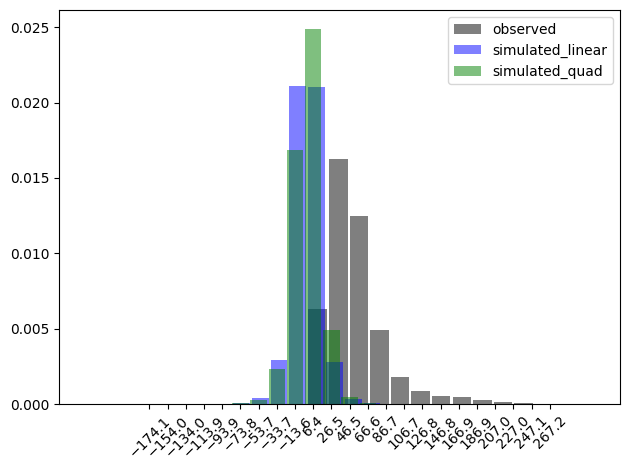

In [ ]:
# Define the model
pan_avg_current_model = LinearModel(pan_avg_current_train, ['Position', 'DistanceToGoal'], 'AvgCurrent', sigma_prior=10)
pan_avg_current_model_quad = QuadraticModel(pan_avg_current_train, ['Position', 'DistanceToGoal'], 'AvgCurrent', sigma_prior=10)

# Sample from the prior
with pan_avg_current_model:
    prior_predictive_pan = pm.sample_prior_predictive(samples=500)
with pan_avg_current_model_quad:
    prior_predictive_pan_quad = pm.sample_prior_predictive(samples=500)

# Plot the prior predictive distribution
az.plot_dist(
    avg_current_data["NeckPan"]["AvgCurrent"],
    kind="hist",
    hist_kwargs={"alpha": 0.5},
    label="observed",
    color="black"
)
az.plot_dist(
    prior_predictive_pan.prior_predictive["likelihood"],
    kind="hist",
    hist_kwargs={"alpha": 0.5},
    label="simulated_linear",
    color="blue"
)
az.plot_dist(
    prior_predictive_pan_quad.prior_predictive["likelihood"],
    kind="hist",
    hist_kwargs={"alpha": 0.5},
    label="simulated_quad",
    color="green"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
with pan_avg_current_model:
    idata_pan = pm.sample(draws=2000, tune=1000, chains=4, cores=6, return_inferencedata=True)
with pan_avg_current_model_quad:
    idata_pan_quad = pm.sample(draws=2000, tune=1000, chains=4, cores=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas]


Output()

Energy change in leapfrog step is too large: 13865809.71492212.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 564937.6908996458.
Energy change in leapfrog step is too large: 3091180874243630.5.
Energy change in leapfrog step is too large: 21907611.712270107.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 382900.02919848287.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 123854.68789013104.
Energy change in leapfrog step is too large: 93021466.44404823.
Energy change in leapfrog step is too large: 1271.990713870121.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 550351.7914509181.
Energy change in leapfrog step is too large: 17065.004991599817.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas_linear, betas_quad]


Output()

Energy change in leapfrog step is too large: 12457286.77394821.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 10978224.51862532.
Energy change in leapfrog step is too large: 10819116.013180884.
Energy change in leapfrog step is too large: 166505.97702131636.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 213871.33559644964.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 141771.35669504342.
Energy change in leapfrog step is too large: 57557.79667471976.
Energy change in leapfrog step is too large: 6999.651489761118.


Energy change in leapfrog step is too large: 716526315.9019933.
Energy change in leapfrog step is too large: inf.
Energy change in leapfrog step is too large: 72988.36237670884.
Energy change in leapfrog step is too large: 3129.7816022664892.
Energy change in leapfrog step is too large: 18752.721698128298.
Energy change in leapfrog step is too large: 2474.7657980073745.
Energy change in leapfrog step is too large: 1807.651881014418.
Energy change in leapfrog step is too large: 2760.663137747739.


Energy change in leapfrog step is too large: 2983.9076362252454.


Energy change in leapfrog step is too large: 1758.5557245243008.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [102]:
#Posterior predictive check
with pan_avg_current_model:
    X_test_matrix = np.stack([pan_avg_current_test[p] for p in ['Position', 'DistanceToGoal']], axis=1)
    # Update all data
    pm.set_data({
        "X_matrix": X_test_matrix,
        "AvgCurrent": pan_avg_current_test['AvgCurrent']
    })
    ppc_pan = pm.sample_posterior_predictive(idata_pan, random_seed=42)



/home/pierre/ikaros/.venv/lib/python3.12/site-packages/pymc/model/core.py:2140: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('Position'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [likelihood]


Output()

In [103]:
predictors = ['Position', 'DistanceToGoal']
with pan_avg_current_model_quad:
    # Prepare test design matrix
    X_test_linear = np.stack([pan_avg_current_test[p] for p in predictors], axis=1)
    X_test_quadratic = np.stack([pan_avg_current_test[p]**2 for p in predictors], axis=1)
    X_test_matrix = np.hstack([X_test_linear, X_test_quadratic])
    
    # Update data
    pm.set_data({
        "X_matrix": X_test_matrix,
        "AvgCurrent": pan_avg_current_test['AvgCurrent']
    })
    
    # Sample posterior predictive
    posterior_pred_pan_quad = pm.sample_posterior_predictive(idata_tilt_quad)

Sampling: [likelihood]


Output()

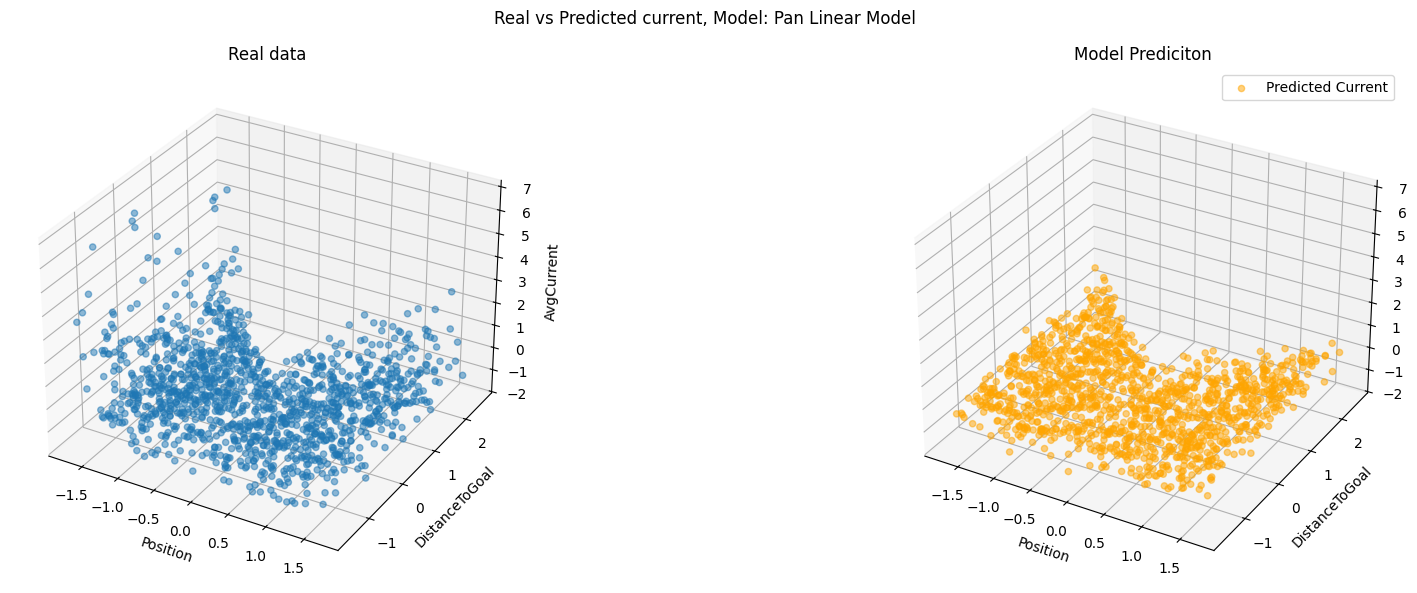

In [106]:
plot_3d_real_vs_predicted(pan_avg_current_test, ppc_pan, indep_var=["Position", "DistanceToGoal"], dep_var=["AvgCurrent", "likelihood"], model_name= "Pan Linear Model")

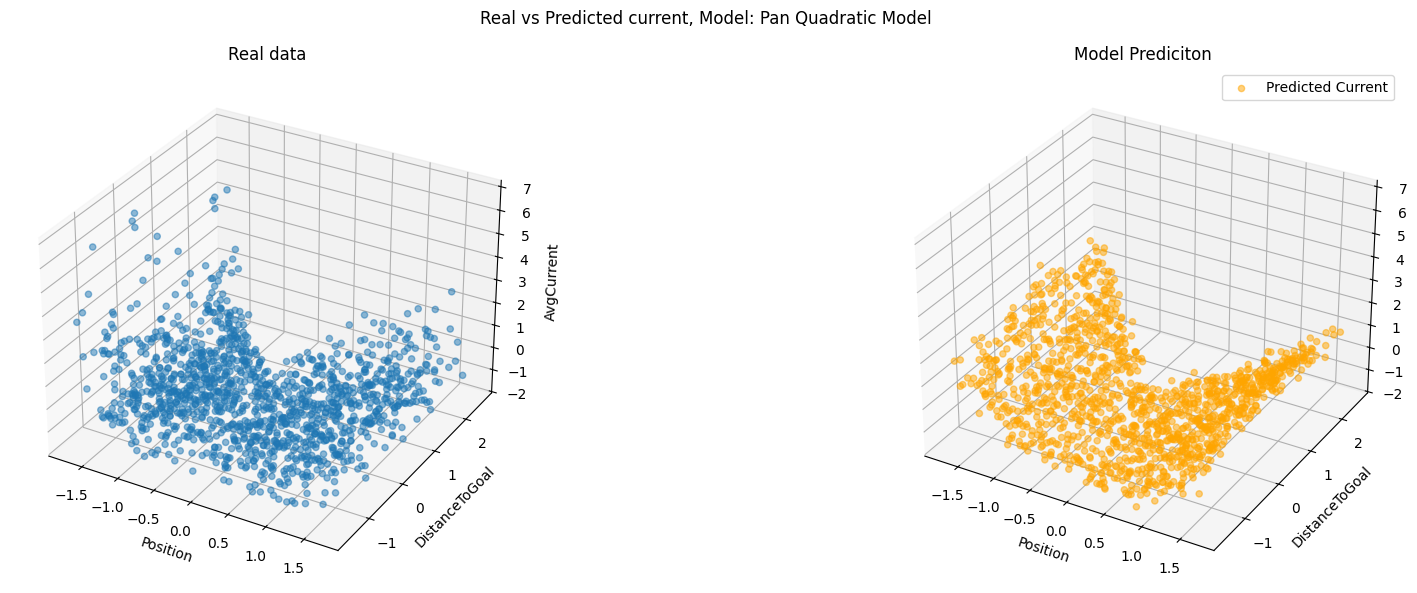

In [107]:
plot_3d_real_vs_predicted(pan_avg_current_test, posterior_pred_pan_quad, indep_var=["Position", "DistanceToGoal"], dep_var=["AvgCurrent", "likelihood"], model_name= "Pan Quadratic Model")

In [117]:
#save the models as nc
idata_tilt.to_netcdf("models/tilt_avg_current_model.nc")
idata_tilt_quad.to_netcdf("models/tilt_avg_current_model_quad.nc")
idata_pan.to_netcdf("models/pan_avg_current_model.nc")
idata_pan_quad.to_netcdf("models/pan_avg_current_model_quad.nc")



'models/pan_avg_current_model_quad.nc'

In [124]:
import arviz as az
import pandas as pd
import json

def save_model_coefficients(models):
    """
    Save coefficients of multiple models to a JSON file.
    
    :param models: Dictionary of model names and their corresponding InferenceData objects
    """
    coefficients = {}
    
    try:
        for model_name, idata in models.items():
            coefficients[model_name] = az.summary(idata).to_dict()
        
        df_coefficients = pd.DataFrame(coefficients)
        
        # Save to JSON file
        output_path = "models/coefficients.json"
        df_coefficients.to_json(output_path)
        print(f"Coefficients saved successfully to {output_path}")
    
    except Exception as e:
        print(f"Error saving coefficients: {str(e)}")

# Usage
models = {
    "tilt_linear": idata_tilt,
    "tilt_quadratic": idata_tilt_quad,
    "pan_linear": idata_pan,
    "pan_quadratic": idata_pan_quad
}

save_model_coefficients(models)


Coefficients saved successfully to models/coefficients.json


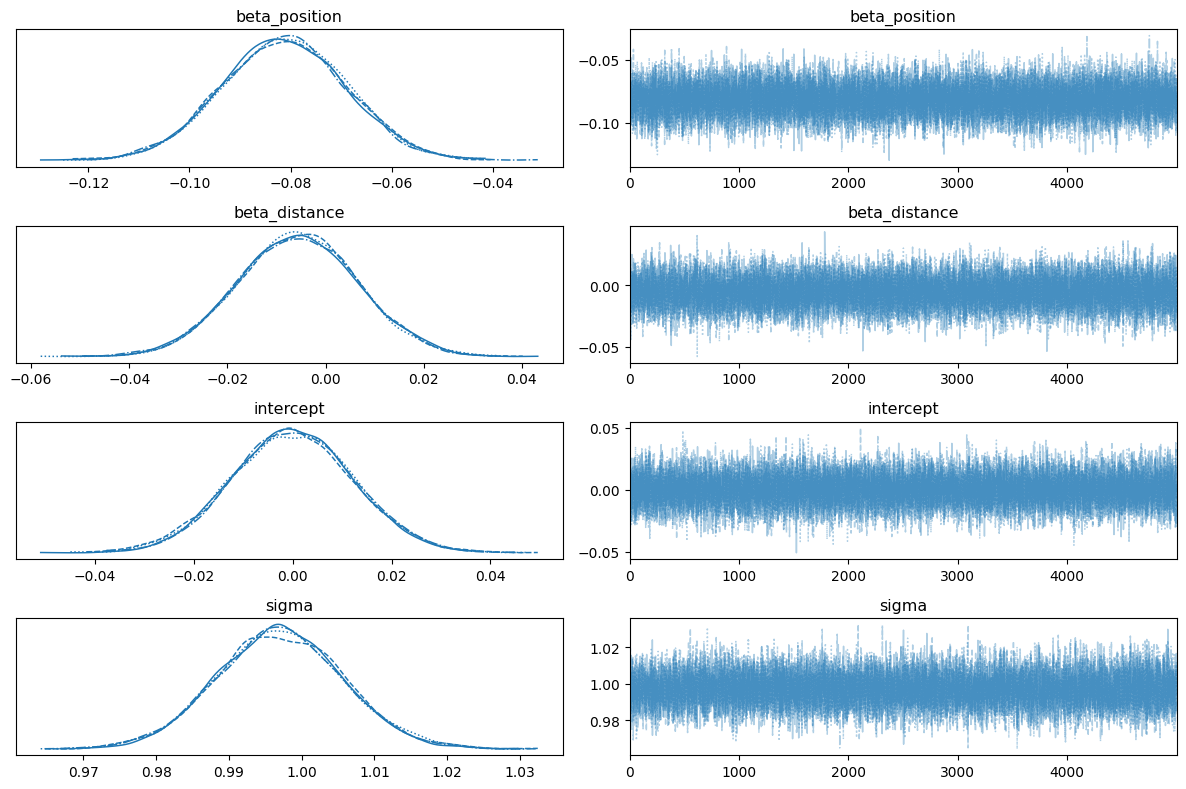

In [13]:
#New model for NeckPan
data = std_avg_current_data["NeckPan"].copy()
trace_file = 'models/trace_pan_avg.nc'

with pm.Model() as regression_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * data['Position'] + beta_distance * data['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_pan = az.from_netcdf(trace_file)
    else:
        trace_pan = pm.sample(5000, tune=1000, target_accept=0.9)
        az.to_netcdf(trace_pan, trace_file)

az.plot_trace(trace_pan)
plt.tight_layout()
plt.show()

In [14]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan = pm.sample_posterior_predictive(trace_pan)


Sampling: [AvgCurrent]


Output()

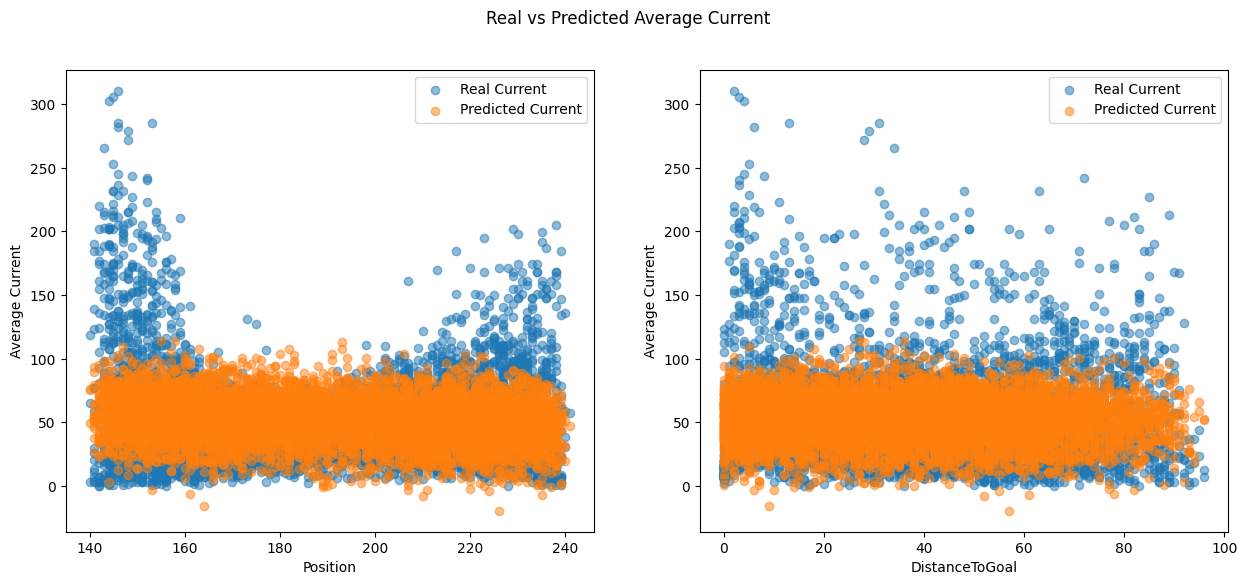

In [15]:

plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan, indep_var=['Position', 'DistanceToGoal'])


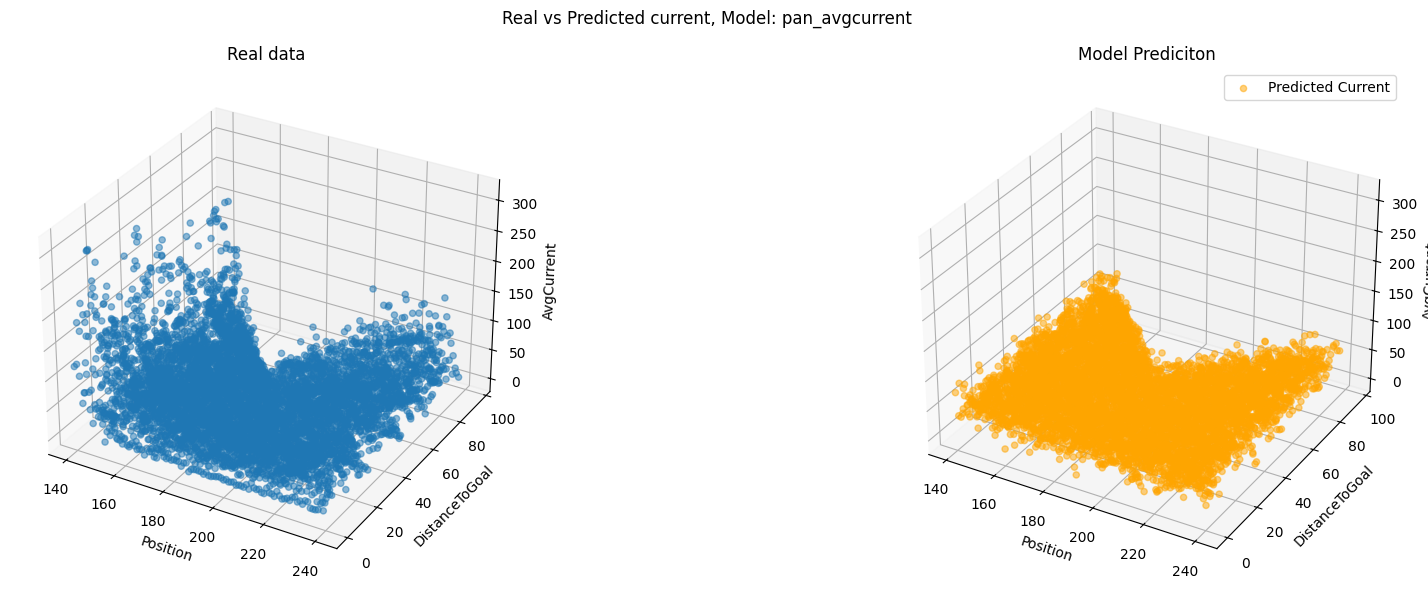

In [33]:
plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan, indep_var=['Position', 'DistanceToGoal'], model_name='pan_avgcurrent')

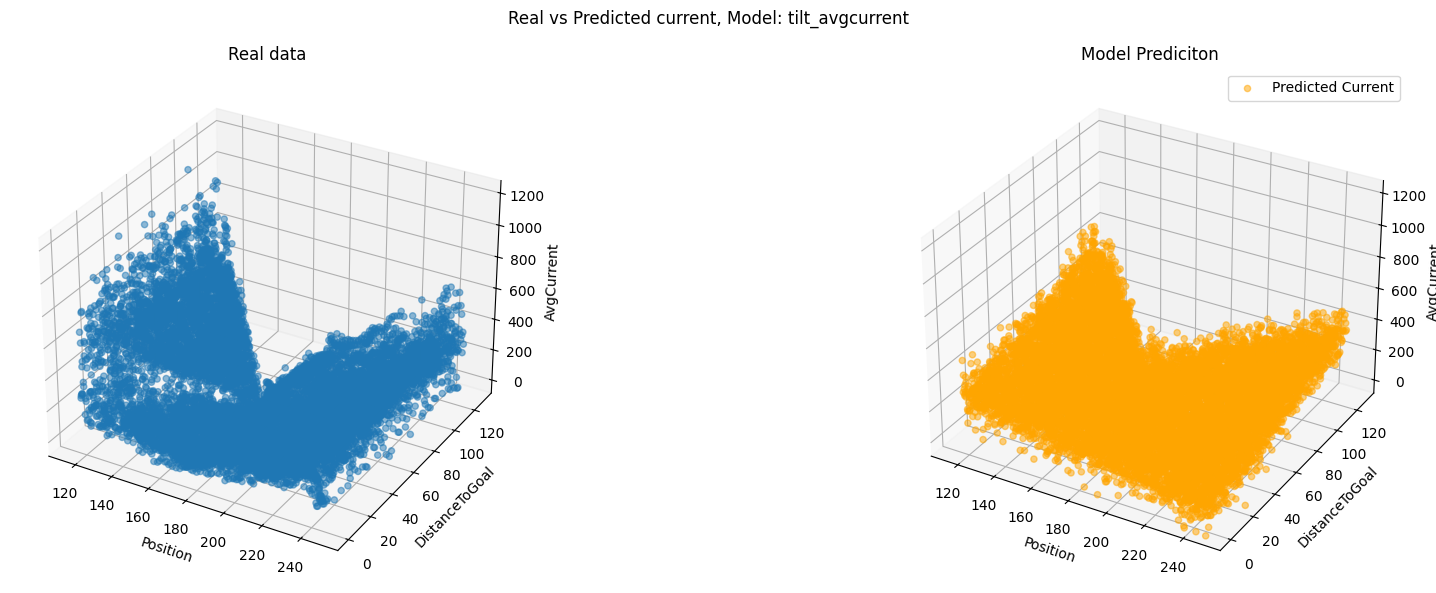

In [34]:
plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt, indep_var=['Position', 'DistanceToGoal'], model_name='tilt_avgcurrent')

## Interaction

In [16]:
#New model for NeckTilit NeackPan Interaction
data = std_avg_current_data["NeckPan"].copy()

trace_file = 'models/trace_tilt_pan_interaction_avg.nc'

with pm.Model() as regression_tilit_pan_model_avg:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position_tilt = pm.Normal('beta_position_tilt', mu=0, sigma=1)
    beta_distance_tilt = pm.Normal('beta_distance_tilt', mu=0, sigma=1)
    beta_position_pan = pm.Normal('beta_position_pan', mu=0, sigma=1)
    beta_distance_pan = pm.Normal('beta_distance_pan', mu=0, sigma=1)

    beta_position_interaction = pm.Normal('beta_position_interaction', mu=0, sigma=1)
    beta_distance_interaction = pm.Normal('beta_distance_interaction', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu_tilt = intercept + beta_position_tilt * data['Position'] + beta_distance_tilt * data['DistanceToGoal'] + beta_position_interaction * data['Position'] * data['DistanceToGoal']
    mu_pan = intercept + beta_position_pan * data['Position'] + beta_distance_pan * data['DistanceToGoal'] + beta_distance_interaction * data['Position'] * data['DistanceToGoal']

    # Likelihood (observed data is normally distributed around mu)
    likelihood_tilt = pm.Normal('AvgCurrentTilt', mu=mu_tilt, sigma=sigma, observed=data['AvgCurrent'])
    likelihood_pan = pm.Normal('AvgCurrentPan', mu=mu_pan, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_tilt_pan_interaction = az.from_netcdf(trace_file)
    else:
        trace_tilt_pan_interaction = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan_interaction, trace_file)

## Quadradic models

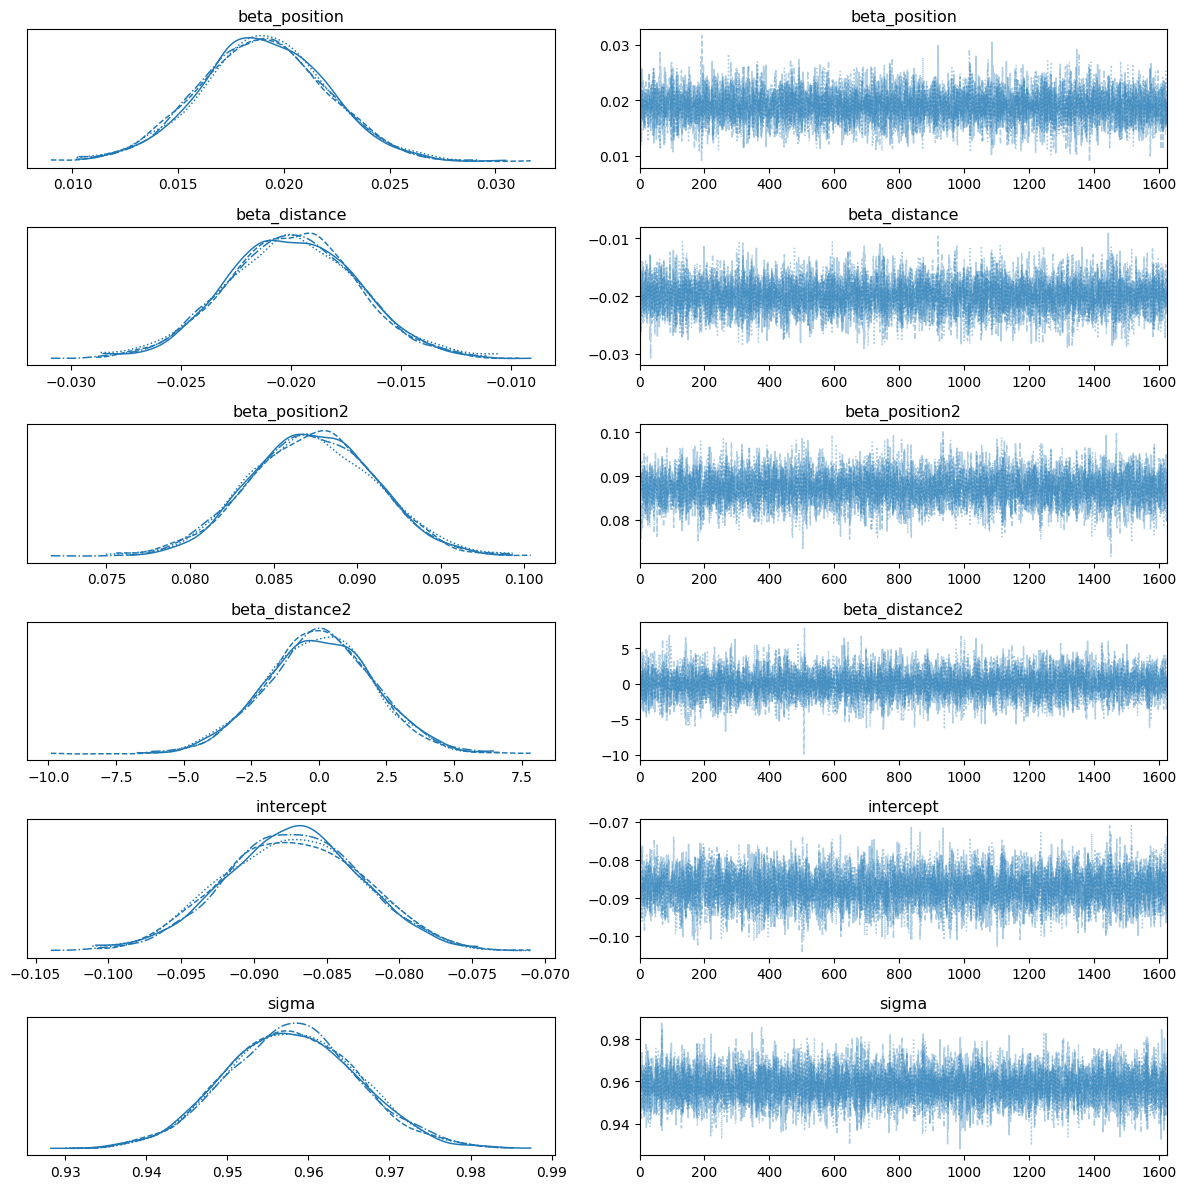

In [17]:
import os
# New polynomial model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

trace_file = 'models/trace_pan_quad_avgcurrent.nc'

with pm.Model() as regression_pan_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)
    

    # Linear model equation
    mu =intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_pan_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_pan_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        # Save the trace with arviz
        az.to_netcdf(trace_pan_quad, trace_file)


az.plot_trace(trace_pan_quad)
plt.tight_layout()
plt.show()

In [18]:
#Posterior Predictive Checks
with regression_pan_model_quadradic:
    ppc_pan_quad = pm.sample_posterior_predictive(trace_pan_quad)


Sampling: [AvgCurrent]


Output()

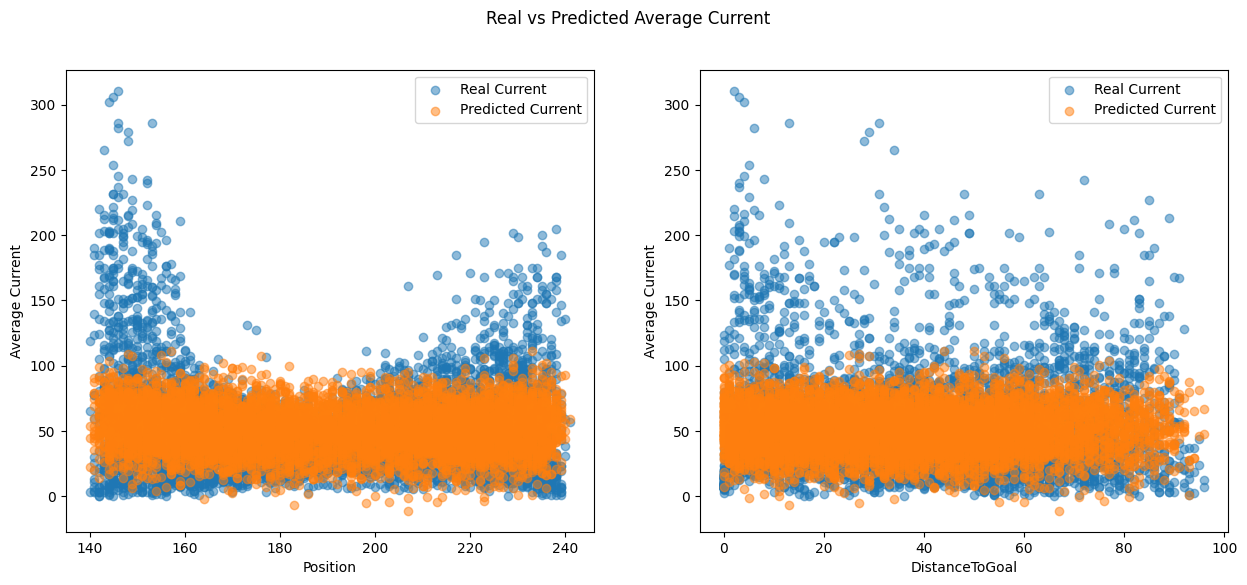

In [19]:
plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

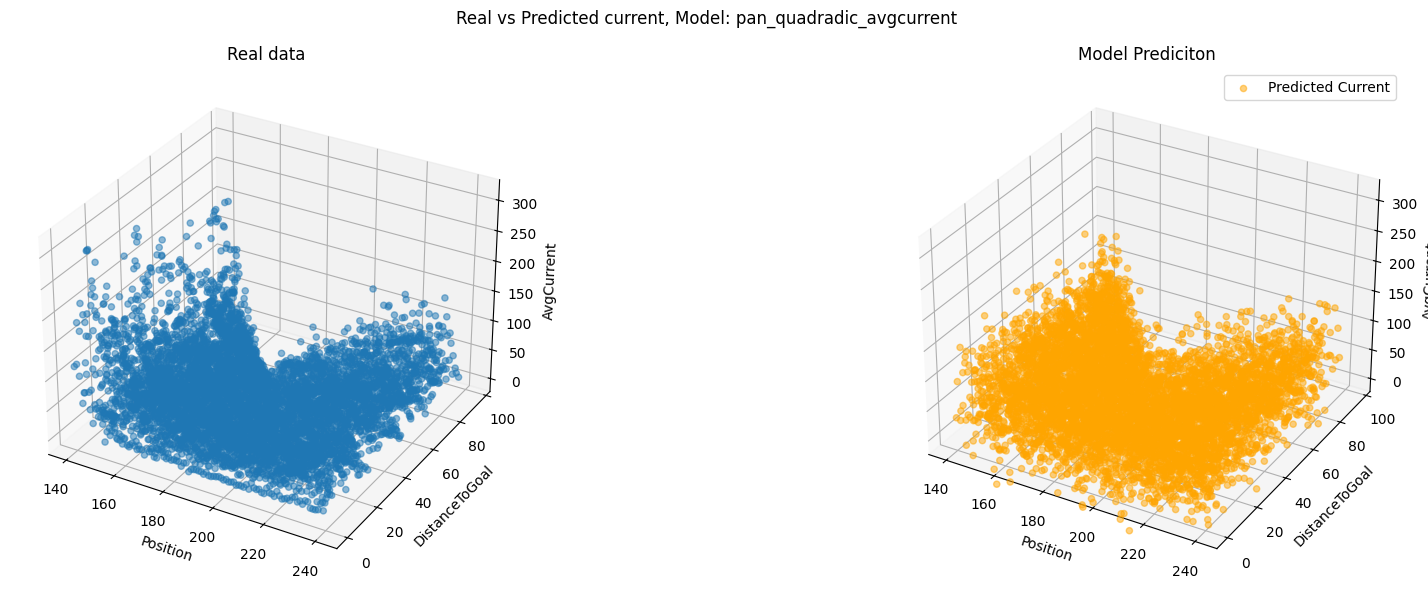

In [20]:
ppc_pan_quad_scaled = ppc_pan_quad.copy()
ppc_pan_quad_scaled.posterior_predictive['AvgCurrent']*=2.5

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad_scaled, indep_var=['Position', 'DistanceToGoal'], model_name='pan_quadradic_avgcurrent')

In [21]:
#Qudratic model for NeckTilt
data = std_avg_current_data["NeckTilt"].copy()

trace_file = 'models/trace_tilt_quad_avgcurrent.nc'

with pm.Model() as regression_tilt_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])

    if os.path.exists(trace_file):
        trace_tilt_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_tilt_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.


In [22]:
with regression_tilt_model_quadradic:
    ppc_tilt_quad = pm.sample_posterior_predictive(trace_tilt_quad)

Sampling: [AvgCurrent]


Output()

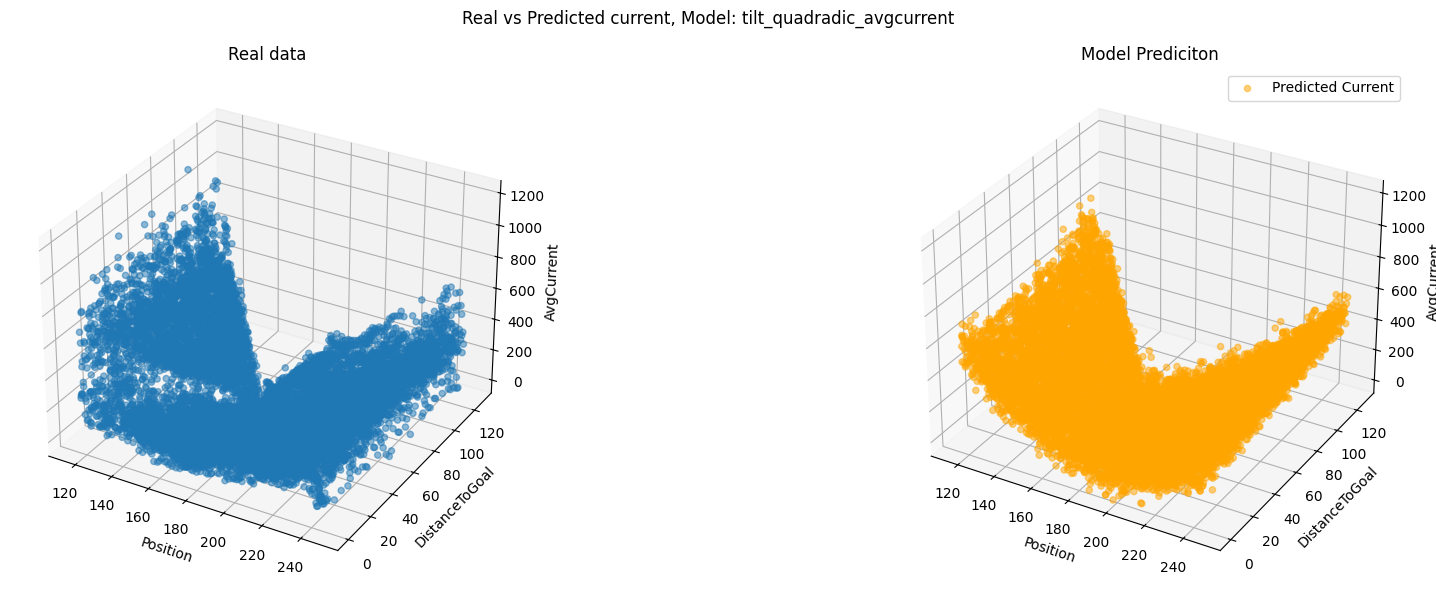

In [23]:
plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad, indep_var=['Position', 'DistanceToGoal'], model_name='tilt_quadradic_avgcurrent')

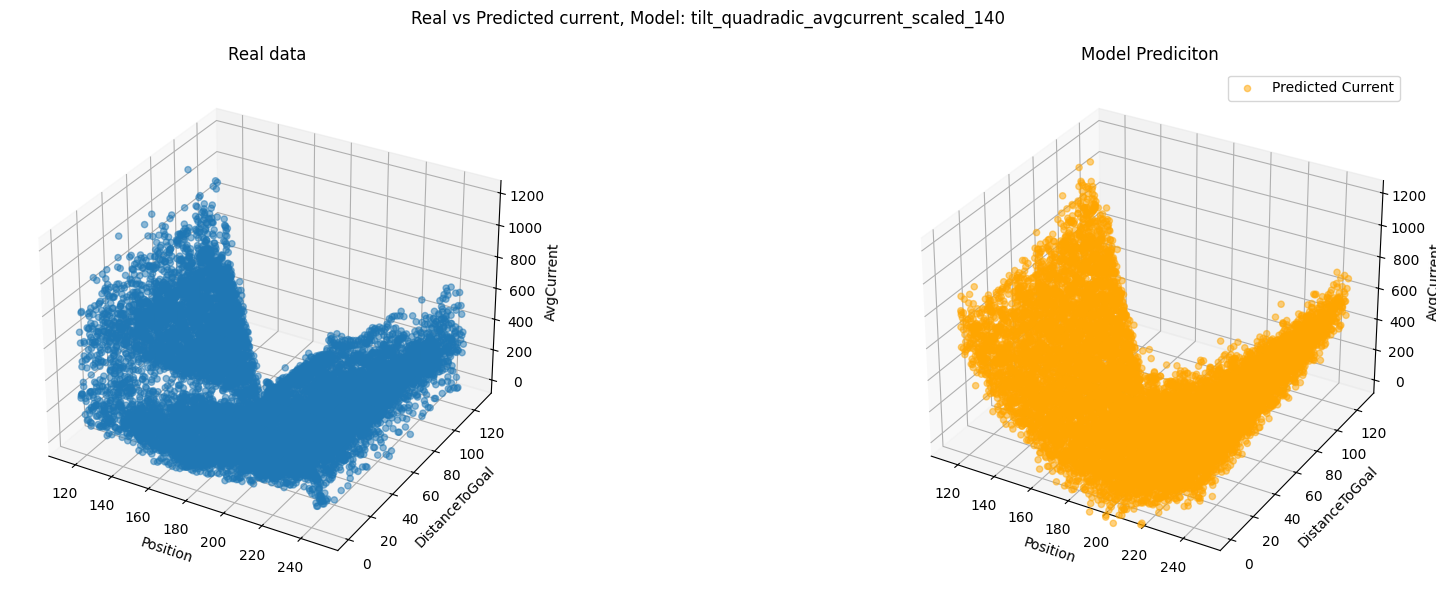

In [35]:
ppc_tilt_quad_scaled = ppc_tilt_quad.copy()
ppc_tilt_quad_scaled.posterior_predictive['AvgCurrent']*=1.4

plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad_scaled, indep_var=['Position', 'DistanceToGoal'], model_name='tilt_quadradic_avgcurrent_scaled_140')

## Pooling servo model

In [25]:
# Combine NeckPan and NeckTilt data
combined_data = pd.concat([avg_current_data["NeckPan"].assign(Servo='NeckPan'), 
                           avg_current_data["NeckTilt"].assign(Servo='NeckTilt')], 
                          ignore_index=True)

combined_data['Servo'] = combined_data['Servo'].astype('category')
combined_data['Servo_index'] = combined_data['Servo'].cat.codes
combined_data_std = combined_data.copy()
for col in combined_data.columns:
    if col in ['Servo', 'Servo_index']:
        continue
    combined_data_std[col] = (combined_data[col] - combined_data[col].mean()) / combined_data[col].std()

In [26]:

# New pooling model with Servo as an index variable
data = combined_data_std.copy()
n_servos = data['Servo'].nunique()
servo_labels = data['Servo'].unique()
servo_idx = data['Servo'].astype('category').cat.codes.values

trace_file = "models/trace_pooling_servos_avg.nc"

# Define coordinates for servo labels
coords = {'servo': servo_labels}

with pm.Model(coords=coords) as pooling_servos_quad_model:
    # Priors for the regression coefficients (using servo labels)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1, dims='servo')
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1, dims='servo')
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=1, dims='servo')
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=1, dims='servo')

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1, dims='servo')
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1, dims='servo')

    # Linear model equation
    mu = (intercept[servo_idx] - beta_position[servo_idx] * data['Position'] + 
          beta_distance[servo_idx] * data['DistanceToGoal'] + 
          beta_position2[servo_idx] * data['Position']**2)
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma[servo_idx], observed=data['AvgCurrent'])

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_pooling_servos_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_pooling_servos_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        # Save the trace to a file
        az.to_netcdf(trace_pooling_servos_quad, trace_file)

# View the summary with servo labels
az.summary(trace_pooling_servos_quad, var_names=['beta_position', 'beta_distance', 'beta_position2', 'beta_distance2', 'intercept', 'sigma'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position[NeckPan]    0.076  0.012   0.054    0.098      0.000    0.000   
beta_position[NeckTilt]   0.283  0.006   0.271    0.294      0.000    0.000   
beta_distance[NeckPan]   -0.080  0.012  -0.103   -0.057      0.000    0.000   
beta_distance[NeckTilt]   0.209  0.006   0.197    0.220      0.000    0.000   
beta_position2[NeckPan]   0.349  0.015   0.322    0.377      0.000    0.000   
beta_position2[NeckTilt]  0.751  0.008   0.737    0.766      0.000    0.000   
beta_distance2[NeckPan]   0.003  0.996  -1.825    1.926      0.005    0.008   
beta_distance2[NeckTilt] -0.005  0.998  -1.885    1.862      0.005    0.008   
intercept[NeckPan]       -0.349  0.019  -0.384   -0.313      0.000    0.000   
intercept[NeckTilt]      -0.751  0.010  -0.769   -0.733      0.000    0.000   
sigma[NeckPan]            0.958  0.008   0.943    0.974      0.000    0.000   
sigma[NeckTilt]           0.640  0.004   0.632    0.648      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
beta_position[NeckPan]     41004.0   14722.0    1.0  
beta_position[NeckTilt]    37042.0   16158.0    1.0  
beta_distance[NeckPan]     35649.0   16438.0    1.0  
beta_distance[NeckTilt]    30336.0   15956.0    1.0  
beta_position2[NeckPan]    20709.0   16258.0    1.0  
beta_position2[NeckTilt]   18852.0   15934.0    1.0  
beta_distance2[NeckPan]    45080.0   14705.0    1.0  
beta_distance2[NeckTilt]   40219.0   15775.0    1.0  
intercept[NeckPan]         20887.0   16634.0    1.0  
intercept[NeckTilt]        19326.0   16072.0    1.0  
sigma[NeckPan]             38626.0   15010.0    1.0  
sigma[NeckTilt]            41724.0   14705.0    1.0

In [27]:
az.summary(trace_tilt_quad)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_position   0.283  0.006   0.271    0.294      0.000    0.000   26564.0   
beta_distance   0.209  0.006   0.197    0.220      0.000    0.000   23901.0   
beta_position2  0.751  0.008   0.736    0.765      0.000    0.000   18962.0   
beta_distance2 -0.017  1.988  -3.805    3.693      0.012    0.015   26792.0   
intercept      -0.751  0.010  -0.770   -0.733      0.000    0.000   20017.0   
sigma           0.640  0.004   0.632    0.648      0.000    0.000   27105.0   

                ess_tail  r_hat  
beta_position    15536.0    1.0  
beta_distance    15461.0    1.0  
beta_position2   15084.0    1.0  
beta_distance2   14773.0    1.0  
intercept        15503.0    1.0  
sigma            15134.0    1.0

In [28]:
with pooling_servos_quad_model:
    ppc_pooling_servos_quad = pm.sample_posterior_predictive(trace_pooling_servos_quad)

Sampling: [AvgCurrent]


Output()

In [29]:
combined_data

Position  DistanceToGoal  AvgCurrent     Servo  Servo_index
0           192               6   36.960000   NeckPan            0
1           191               5   48.414545   NeckPan            0
2           190               4   30.240000   NeckPan            0
3           189               3   28.332973   NeckPan            0
4           188               2   34.160000   NeckPan            0
...         ...             ...         ...       ...          ...
18368       124              61  414.556279  NeckTilt            1
18369       125              61  803.880000  NeckTilt            1
18370       125              60  789.600000  NeckTilt            1
18371       126              59  651.840000  NeckTilt            1
18372       132              54  493.920000  NeckTilt            1

[18373 rows x 5 columns]

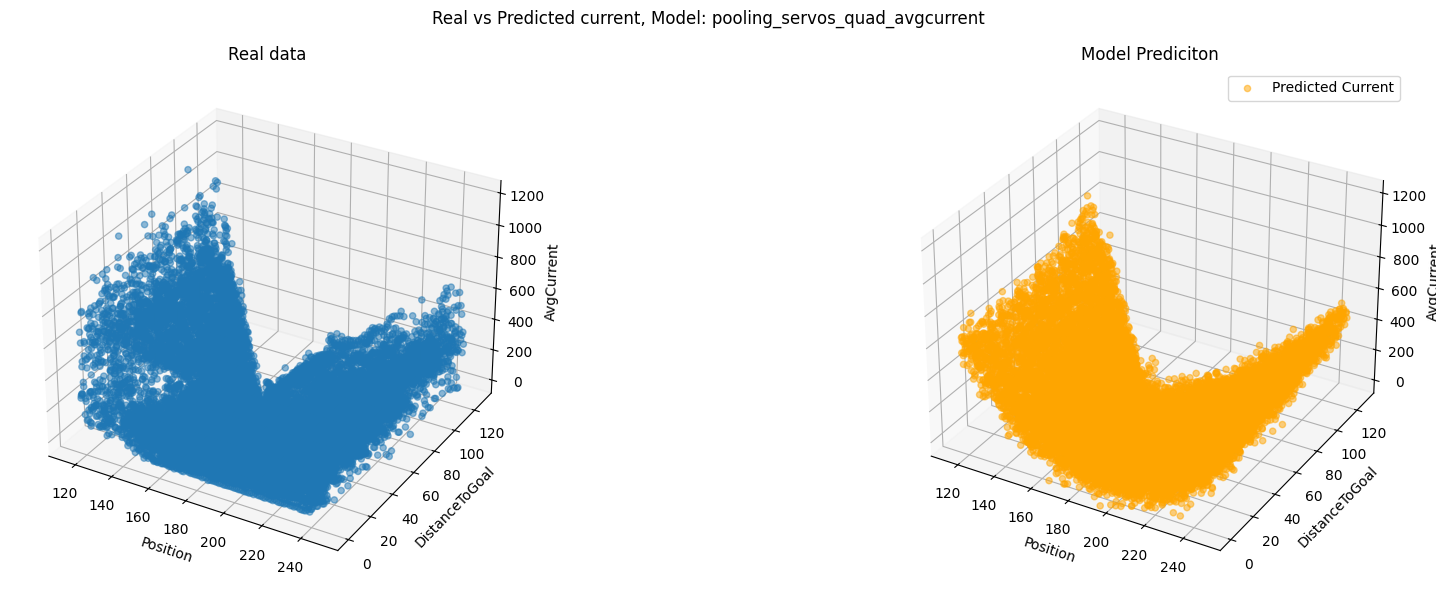

In [30]:
plot_3d_real_vs_predicted(combined_data, ppc_pooling_servos_quad, indep_var=['Position', 'DistanceToGoal'], model_name='pooling_servos_quad_avgcurrent')

In [31]:
with regression_tilt_model:
    pm.compute_log_likelihood(trace_tilt)

with regression_pan_model:
    pm.compute_log_likelihood(trace_pan)

with regression_tilt_model_quadradic:
    pm.compute_log_likelihood(trace_tilt_quad)

with regression_pan_model_quadradic:
    pm.compute_log_likelihood(trace_pan_quad)

with pooling_servos_quad_model:
    pm.compute_log_likelihood(trace_pooling_servos_quad)


Output()

Output()

Output()

Output()

Output()

In [32]:
with pooling_servos_quad_model:
    pm.compute_log_likelihood(trace_pooling_servos_quad)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

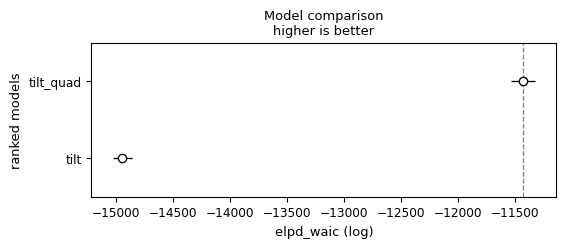

In [34]:
az.plot_compare(tilt_model_comparison)
plt.show()

In [32]:

pan_model_comparison_WAIC = az.compare({'pan': trace_pan, 'pan_quad': trace_pan_quad}, ic='waic')

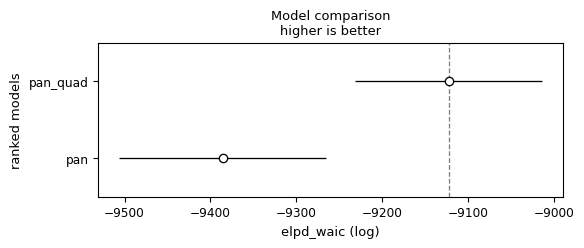

In [59]:
az.plot_compare(pan_model_comparison_WAIC)
plt.show()

In [46]:
## waic of pooling model
pooling_model_WAIC = az.waic(trace_pooling_servos_quad)
pooling_model_WAIC

Computed from 20000 posterior samples and 18373 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -20546.73   153.69
p_waic       16.78        -

In [47]:
ppc_pooling_servos_quad

Inference data with groups:
	> posterior_predictive
	> observed_data

# Models using batched data

In [11]:
batch_size = avg_current_data["NeckPan"].shape[0]  
data = std_all_data.copy()

# Define mini-batches for each variable

tilt_pos_batch = pm.Minibatch(data['tilt_pos'], batch_size=batch_size)
tilt_distance_batch = pm.Minibatch(data['tilt_distance'], batch_size=batch_size)
pan_pos_batch = pm.Minibatch(data['pan_pos'], batch_size=batch_size)
pan_distance_batch = pm.Minibatch(data['pan_distance'], batch_size=batch_size)
tilt_current_batch = pm.Minibatch(data['tilt_current'], batch_size=batch_size)
pan_current_batch = pm.Minibatch(data['pan_current'], batch_size=batch_size)

In [12]:
import os

# Define the file path for saving the trace
trace_file = 'models/trace_tilt_quad_all_std_VI.nc'

# New tilt quadric model using all the data
data = std_all_data.copy()

with pm.Model() as regression_tilt_model_quadradic_all:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['tilt_pos'] + beta_distance * data['tilt_distance'] + beta_position2 * data['tilt_pos']**2

    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('tilt_current', mu=mu, sigma=sigma, observed=data['tilt_current'])

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_tilt_quad_all = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        approx = pm.fit(n=batch_size, method='advi')
        trace_tilt_quad_all = approx.sample(5000)

        # Save the trace to a file
        az.to_netcdf(trace_tilt_quad_all, trace_file)

# Summarize the trace
az.summary(trace_tilt_quad_all)

Output()

Finished [100%]: Average Loss = 9.4199e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_position   0.781  0.283   0.246    1.307      0.004    0.003    4663.0   
beta_distance   0.100  0.259  -0.373    0.600      0.004    0.003    4993.0   
beta_position2  0.177  0.285  -0.373    0.700      0.004    0.003    5041.0   
beta_distance2 -0.018  1.688  -3.157    3.114      0.024    0.017    5084.0   
intercept      -0.137  0.308  -0.689    0.457      0.004    0.003    5007.0   
sigma           1.002  0.298   0.488    1.549      0.004    0.003    4924.0   

                ess_tail  r_hat  
beta_position     4971.0    NaN  
beta_distance     5025.0    NaN  
beta_position2    4859.0    NaN  
beta_distance2    4821.0    NaN  
intercept         4619.0    NaN  
sigma             5110.0    NaN

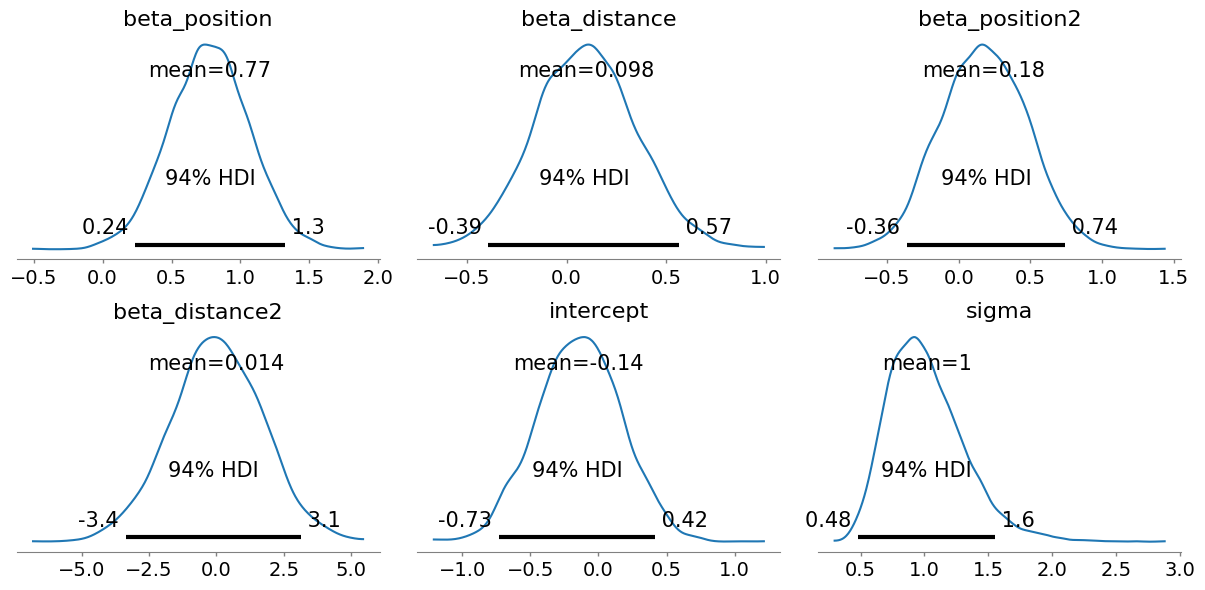

In [12]:
az.plot_posterior(trace_tilt_quad_all, var_names=['beta_position', 'beta_distance', 'beta_position2', 'beta_distance2', 'intercept', 'sigma'], figsize=(12, 6))
plt.tight_layout()
plt.show()

In [13]:
import pymc as pm
import arviz as az
import numpy as np
import gc  # Import garbage collection to manage memory

# Define the number of chunks and chunk size
num_samples = 5000  # Total number of posterior samples you want to use
chunk_size = 1000   # Number of samples per chunk

# Calculate the number of chunks
num_chunks = num_samples // chunk_size

# Loop over chunks to sample posterior predictive
ppc_chunks = []

with regression_tilt_model_quadradic_all:
    for i in range(num_chunks):
        print(f"Starting sampling for chunk {i+1} of {num_chunks}...")

        # Slice the trace manually for each chunk
        trace_chunk = trace_tilt_quad_all.isel(draw=slice(i * chunk_size, (i + 1) * chunk_size))
        
        # Attempt sampling and saving, with diagnostics
        try:
            # Generate posterior predictive samples for this chunk
            ppc_chunk = pm.sample_posterior_predictive(trace_chunk)
            
            # Store each chunk or save it to disk
            ppc_chunks.append(ppc_chunk)
            
            # Save each chunk to disk
            file_path = f'models/ppc_tilt_quad_all_chunk_{i+1}.nc'
            az.to_netcdf(ppc_chunk, file_path)
            print(f"Saved chunk {i+1} to {file_path}")

        except Exception as e:
            print(f"Error encountered during sampling of chunk {i+1}: {e}")
            break  # Exit the loop if there’s an error
        
        # Free up memory after each chunk to ensure we don't hold onto large objects
        del ppc_chunk, trace_chunk  # Delete variables to free memory
        gc.collect()  # Call garbage collection explicitly

        print(f"Finished chunk {i+1}, moving to the next chunk.")
        
print("All chunks sampled and saved.")


Sampling: [tilt_current]


Output()

Starting sampling for chunk 1 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 1 to models/ppc_tilt_quad_all_chunk_1.nc
Finished chunk 1, moving to the next chunk.
Starting sampling for chunk 2 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 2 to models/ppc_tilt_quad_all_chunk_2.nc
Finished chunk 2, moving to the next chunk.
Starting sampling for chunk 3 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 3 to models/ppc_tilt_quad_all_chunk_3.nc
Finished chunk 3, moving to the next chunk.
Starting sampling for chunk 4 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 4 to models/ppc_tilt_quad_all_chunk_4.nc
Finished chunk 4, moving to the next chunk.
Starting sampling for chunk 5 of 5...


In [13]:
subdata = all_data.sample(batch_size)

plot_3d_real_vs_predicted(subdata, ppc_tilt_quad_all, dep_var=["tilt_current", "tilt_current"], indep_var=['tilt_pos', 'tilt_distance'], model_name='tilt_quadradic_batched_VI')

NameError: name 'ppc_tilt_quad_all' is not defined

NameError: name 'ppc_tilt_quad_all' is not defined

In [ ]:
plot_3d_real_vs_predicted(data, ppc_tilt_quad_all, dep_var=["tilt_current", "tilt_current"], indep_var=['tilt_pos', 'tilt_distance'], model_name='tilt_quad_batched')

NameError: name 'ppc_tilt_quad_all' is not defined

In [129]:
trace_file = 'models/trace_tilt_pan_comb_all_std_VI.nc'


with pm.Model() as regression_tilt_pan_model:
    # Priors for regression coefficients
    beta_position_tilt_raw = pm.Normal('beta_position_tilt_raw', mu=0, sigma=1)
    beta_position_tilt = pm.Deterministic('beta_position_tilt_unique', 0 + 1 * beta_position_tilt_raw)
    beta_distance_tilt_raw = pm.Normal('beta_distance_tilt_raw', mu=0, sigma=1)
    beta_distance_tilt = pm.Deterministic('beta_distance_tilt_unique', 0 + 1 * beta_distance_tilt_raw)
    beta_position_tilt2_raw = pm.Normal('beta_position_tilt2_raw', mu=0, sigma=1)
    beta_position_tilt2 = pm.Deterministic('beta_position_tilt2_unique', 0 + 1 * beta_position_tilt2_raw)
    beta_distance_tilt2_raw = pm.Normal('beta_distance_tilt2_raw', mu=0, sigma=1)
    beta_distance_tilt2 = pm.Deterministic('beta_distance_tilt2_unique', 0 + 1 * beta_distance_tilt2_raw)
    beta_position_pan_raw = pm.Normal('beta_position_pan_raw', mu=0, sigma=1)
    beta_position_pan = pm.Deterministic('beta_position_pan_unique', 0 + 1 * beta_position_pan_raw)
    beta_distance_pan_raw = pm.Normal('beta_distance_pan_raw', mu=0, sigma=1)
    beta_distance_pan = pm.Deterministic('beta_distance_pan_unique', 0 + 1 * beta_distance_pan_raw)
    beta_position_pan2_raw = pm.Normal('beta_position_pan2_raw', mu=0, sigma=1)
    beta_position_pan2 = pm.Deterministic('beta_position_pan2_unique', 0 + 1 * beta_position_pan2_raw)
    beta_distance_pan2_raw = pm.Normal('beta_distance_pan2_raw', mu=0, sigma=1)
    beta_distance_pan2 = pm.Deterministic('beta_distance_pan2', 0 + 1 * beta_distance_pan2_raw)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma_tilt = pm.HalfNormal('sigma_tilt', sigma=1)
    sigma_pan = pm.HalfNormal('sigma_pan', sigma=1)

    # Linear model equations with mini-batch variables
    mu_tilt = (intercept + beta_position_tilt * tilt_pos_batch + beta_distance_tilt * tilt_distance_batch + 
               beta_position_tilt2 * tilt_pos_batch**2  + 
               beta_distance_tilt2 * tilt_distance_batch**2)
               
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma_tilt, observed=tilt_current_batch)

    mu_pan = (intercept + beta_position_pan * pan_pos_batch + beta_distance_pan * pan_distance_batch + 
              beta_position_pan2 * pan_pos_batch**2 + beta_distance_pan2 * pan_distance_batch**2 + 
              beta_position_tilt * tilt_pos_batch + beta_position_tilt2 * tilt_pos_batch**2)
    
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma_pan, observed=pan_current_batch)

    if os.path.exists(trace_file):
        # Load existing trace
        trace_tilt_pan = az.from_netcdf(trace_file)
    else:
        # Fit with ADVI and save the trace
        approx = pm.fit(30000, method="fullrank_advi", progressbar=True)
        trace_tilt_pan = approx.sample(1000)
        #trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan, trace_file)

az.summary(trace_tilt_pan) 


Output()

Finished [100%]: Average Loss = 14,218
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position_tilt_raw     -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_raw      0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_raw    -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_raw    -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_raw       0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_raw       0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_raw      0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2_raw     -0.000  0.045  -0.084    0.083      0.001    0.001   
intercept                   0.005  0.052  -0.089    0.104      0.002    0.001   
sigma_tilt                  1.001  0.015   0.976    1.030      0.001    0.000   
sigma_pan                   1.000  0.022   0.957    1.040      0.001    0.001   
beta_position_tilt_unique  -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_unique   0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_unique -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_unique -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_unique    0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_unique    0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_unique   0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2         -0.000  0.045  -0.084    0.083      0.001    0.001   

                            ess_bulk  ess_tail  r_hat  
beta_position_tilt_raw         959.0     860.0    NaN  
beta_distance_tilt_raw         969.0     946.0    NaN  
beta_position_tilt2_raw        836.0     851.0    NaN  
beta_distance_tilt2_raw        980.0     722.0    NaN  
beta_position_pan_raw          966.0     981.0    NaN  
beta_distance_pan_raw         1001.0     793.0    NaN  
beta_position_pan2_raw         890.0     843.0    NaN  
beta_distance_pan2_raw         953.0     837.0    NaN  
intercept                      813.0     794.0    NaN  
sigma_tilt                     787.0     775.0    NaN  
sigma_pan                      878.0     919.0    NaN  
beta_position_tilt_unique      959.0     860.0    NaN  
beta_distance_tilt_unique      969.0     946.0    NaN  
beta_position_tilt2_unique     836.0     851.0    NaN  
beta_distance_tilt2_unique     980.0     722.0    NaN  
beta_position_pan_unique       966.0     981.0    NaN  
beta_distance_pan_unique      1001.0     793.0    NaN  
beta_position_pan2_unique      890.0     843.0    NaN  
beta_distance_pan2             953.0     837.0    NaN

In [130]:
with regression_tilt_pan_model:
    ppc_tilt_pan = pm.sample_posterior_predictive(trace_tilt_pan)

Sampling: [PanCurrent, TiltCurrent]


Output()

In [ ]:
trace_file = 'models/trace_tilt_pan_comb_all_std_VI.nc'


with pm.Model() as regression_tilt_pan_model:
    # Priors for regression coefficients
    beta_position_tilt_raw = pm.Normal('beta_position_tilt_raw', mu=0, sigma=1)
    beta_position_tilt = pm.Deterministic('beta_position_tilt_unique', 0 + 1 * beta_position_tilt_raw)
    beta_distance_tilt_raw = pm.Normal('beta_distance_tilt_raw', mu=0, sigma=1)
    beta_distance_tilt = pm.Deterministic('beta_distance_tilt_unique', 0 + 1 * beta_distance_tilt_raw)
    beta_position_tilt2_raw = pm.Normal('beta_position_tilt2_raw', mu=0, sigma=1)
    beta_position_tilt2 = pm.Deterministic('beta_position_tilt2_unique', 0 + 1 * beta_position_tilt2_raw)
    beta_distance_tilt2_raw = pm.Normal('beta_distance_tilt2_raw', mu=0, sigma=1)
    beta_distance_tilt2 = pm.Deterministic('beta_distance_tilt2_unique', 0 + 1 * beta_distance_tilt2_raw)
    beta_position_pan_raw = pm.Normal('beta_position_pan_raw', mu=0, sigma=1)
    beta_position_pan = pm.Deterministic('beta_position_pan_unique', 0 + 1 * beta_position_pan_raw)
    beta_distance_pan_raw = pm.Normal('beta_distance_pan_raw', mu=0, sigma=1)
    beta_distance_pan = pm.Deterministic('beta_distance_pan_unique', 0 + 1 * beta_distance_pan_raw)
    beta_position_pan2_raw = pm.Normal('beta_position_pan2_raw', mu=0, sigma=1)
    beta_position_pan2 = pm.Deterministic('beta_position_pan2_unique', 0 + 1 * beta_position_pan2_raw)
    beta_distance_pan2_raw = pm.Normal('beta_distance_pan2_raw', mu=0, sigma=1)
    beta_distance_pan2 = pm.Deterministic('beta_distance_pan2', 0 + 1 * beta_distance_pan2_raw)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma_tilt = pm.HalfNormal('sigma_tilt', sigma=1)
    sigma_pan = pm.HalfNormal('sigma_pan', sigma=1)

    # Linear model equations with mini-batch variables
    mu_tilt = (intercept + beta_position_tilt * tilt_pos_batch + beta_distance_tilt * tilt_distance_batch + 
               beta_position_tilt2 * tilt_pos_batch**2  + 
               beta_distance_tilt2 * tilt_distance_batch**2)
               
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma_tilt, observed=tilt_current_batch)

    mu_pan = (intercept + beta_position_pan * pan_pos_batch + beta_distance_pan * pan_distance_batch + 
              beta_position_pan2 * pan_pos_batch**2 + beta_distance_pan2 * pan_distance_batch**2 + 
              beta_position_tilt * tilt_pos_batch + beta_position_tilt2 * tilt_pos_batch**2)
    
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma_pan, observed=pan_current_batch)

    if os.path.exists(trace_file):
        # Load existing trace
        trace_tilt_pan = az.from_netcdf(trace_file)
    else:
        # Fit with ADVI and save the trace
        approx = pm.fit(30000, method="fullrank_advi", progressbar=True)
        trace_tilt_pan = approx.sample(1000)
        #trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan, trace_file)

az.summary(trace_tilt_pan) 


Output()

Finished [100%]: Average Loss = 14,218
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position_tilt_raw     -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_raw      0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_raw    -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_raw    -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_raw       0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_raw       0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_raw      0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2_raw     -0.000  0.045  -0.084    0.083      0.001    0.001   
intercept                   0.005  0.052  -0.089    0.104      0.002    0.001   
sigma_tilt                  1.001  0.015   0.976    1.030      0.001    0.000   
sigma_pan                   1.000  0.022   0.957    1.040      0.001    0.001   
beta_position_tilt_unique  -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_unique   0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_unique -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_unique -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_unique    0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_unique    0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_unique   0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2         -0.000  0.045  -0.084    0.083      0.001    0.001   

                            ess_bulk  ess_tail  r_hat  
beta_position_tilt_raw         959.0     860.0    NaN  
beta_distance_tilt_raw         969.0     946.0    NaN  
beta_position_tilt2_raw        836.0     851.0    NaN  
beta_distance_tilt2_raw        980.0     722.0    NaN  
beta_position_pan_raw          966.0     981.0    NaN  
beta_distance_pan_raw         1001.0     793.0    NaN  
beta_position_pan2_raw         890.0     843.0    NaN  
beta_distance_pan2_raw         953.0     837.0    NaN  
intercept                      813.0     794.0    NaN  
sigma_tilt                     787.0     775.0    NaN  
sigma_pan                      878.0     919.0    NaN  
beta_position_tilt_unique      959.0     860.0    NaN  
beta_distance_tilt_unique      969.0     946.0    NaN  
beta_position_tilt2_unique     836.0     851.0    NaN  
beta_distance_tilt2_unique     980.0     722.0    NaN  
beta_position_pan_unique       966.0     981.0    NaN  
beta_distance_pan_unique      1001.0     793.0    NaN  
beta_position_pan2_unique      890.0     843.0    NaN  
beta_distance_pan2             953.0     837.0    NaN

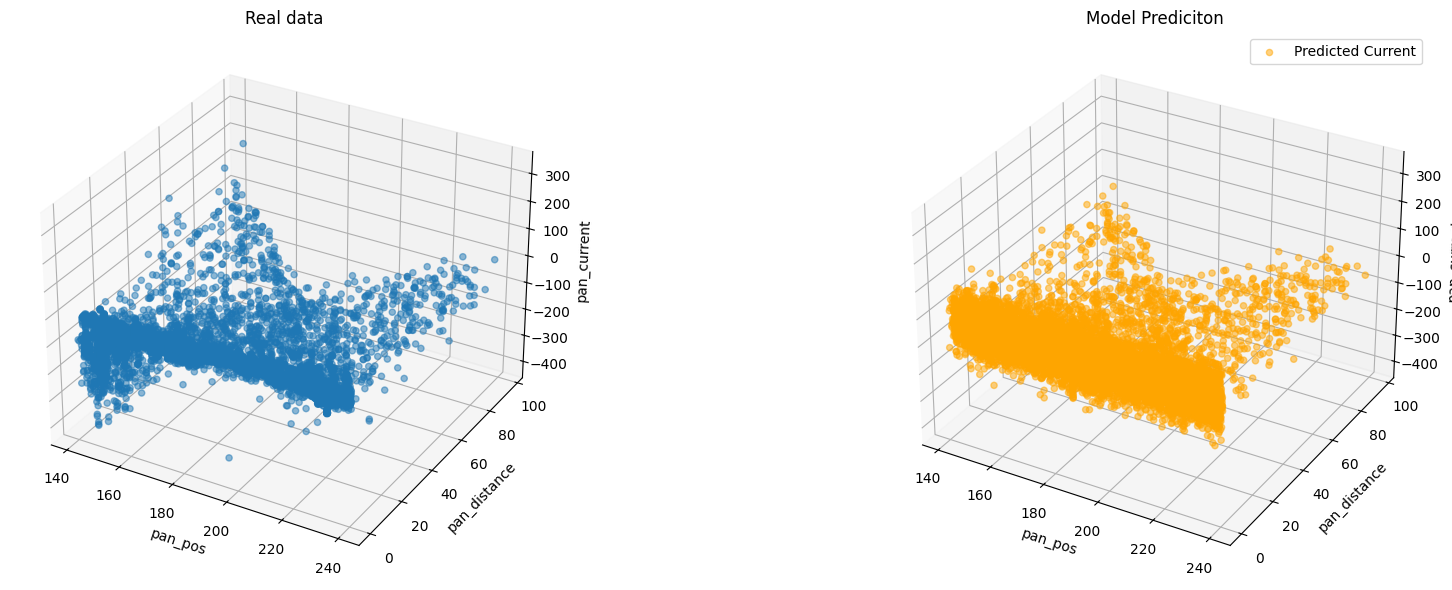

In [95]:
plot_3d_real_vs_predicted(subdata, ppc_tilt_pan, dep_var=["pan_current", "PanCurrent"], indep_var=['pan_pos', 'pan_distance'], model_name='TiltPan_batched-pan')

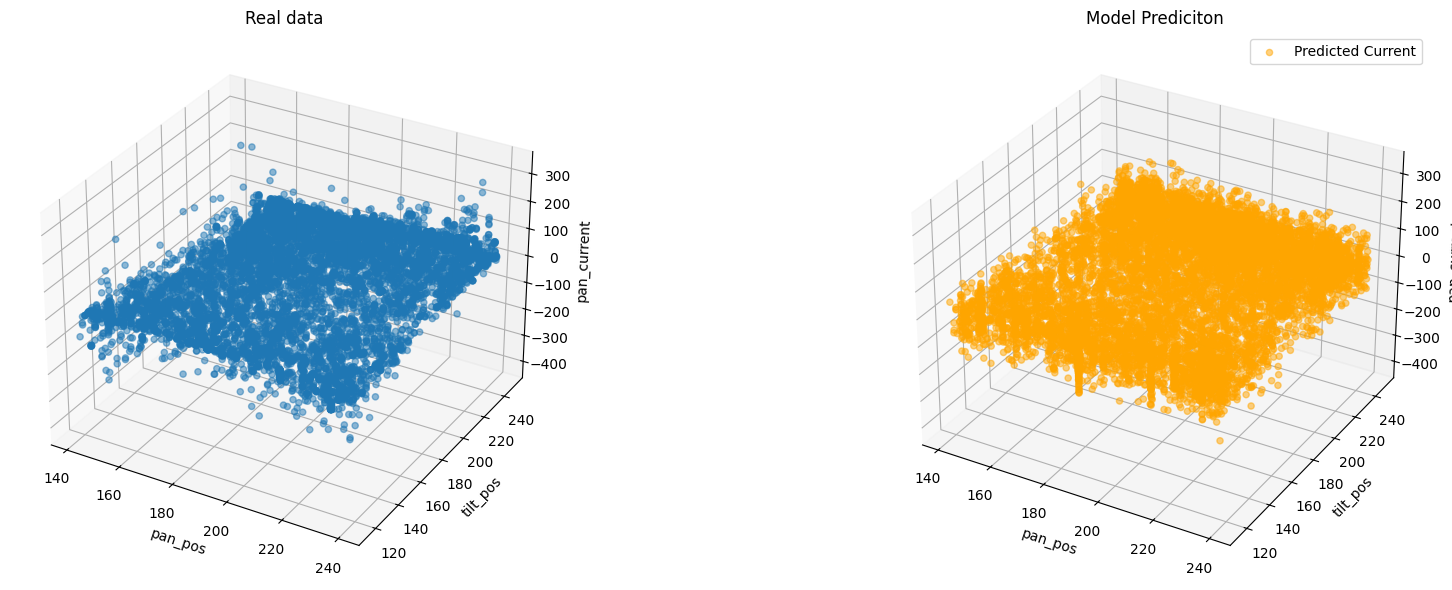

In [97]:
plot_3d_real_vs_predicted(subdata, ppc_tilt_pan, dep_var=["pan_current", "PanCurrent"], indep_var=['pan_pos', 'tilt_pos'], model_name='TiltPan_batched-pan')

In [113]:
all_data

tilt_pos  pan_pos  tilt_current  pan_current  gyro_x  gyro_y  gyro_z  \
0         176.35   192.35          0.00         0.00   -0.46    0.49   -0.43   
1         176.35   192.35          0.00         0.00   -0.07    0.58    0.00   
2         176.35   192.35        -23.52       -23.52   -0.03    0.55    0.64   
3         176.44   192.35        -26.88       -26.88   -1.10    0.67    0.52   
4         176.35   192.35        -26.88       -26.88   -0.46   -0.09    1.12   
...          ...      ...           ...          ...     ...     ...     ...   
700862    180.57   180.04       -151.20       -10.08   12.86   71.64   -2.23   
700863    180.04   180.13       -124.32        -6.72   13.41   72.36   -2.16   
700864    179.52   180.04        -53.76       -10.08   13.93   73.57   -1.83   
700865    178.90   180.04        -77.28        -6.72   13.77   73.44   -1.19   
700866    178.37   180.13        268.80       -10.08   12.68   69.99   -0.13   

        accel_x  accel_y  accel_z  tilt_distance  pan_distance  
0          0.00     0.00     0.00          17.58          6.42  
1          0.23    -0.03    -0.94          17.58          6.42  
2          0.23    -0.03    -0.94          17.58          6.42  
3          0.23    -0.03    -0.94          17.67          6.42  
4          0.23    -0.03    -0.94          17.58          6.42  
...         ...      ...      ...            ...           ...  
700862     0.05    -0.04    -0.93           2.20          0.09  
700863     0.06    -0.04    -0.93           1.67          0.00  
700864     0.08    -0.04    -0.93           1.15          0.09  
700865     0.09    -0.04    -0.93           0.53          0.09  
700866     0.09    -0.04    -0.93           0.00          0.00  

[700867 rows x 12 columns]

# Playground

In [ ]:
import pytensor.tensor as pt
X = train_data.drop(columns=['UniqueID', 'TiltCurrent', 'PanCurrent'])
y = train_data['TiltCurrent']
D0 = 4
N, D = X.shape

with pm.Model(coords={"predictors": X.columns.values}) as tilit_current_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 400)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("current", beta0 + pt.dot(X.values, beta), sigma, observed=y.values)


    prior_samples = pm.sample_prior_predictive(100)



Sampling: [beta0, c2, current, lam, sigma, tau, z]


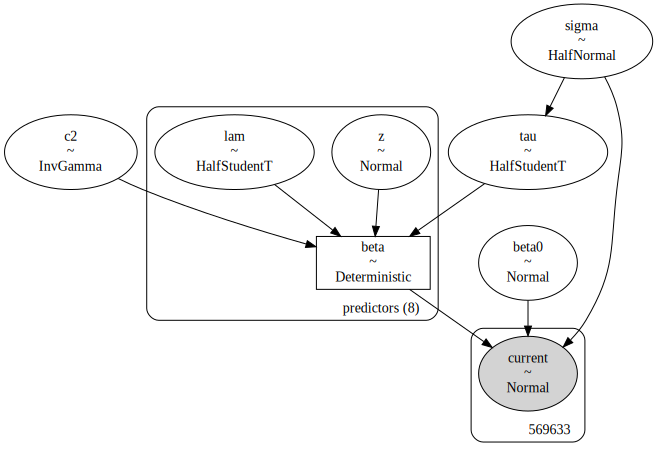

In [ ]:
pm.model_to_graphviz(tilit_current_model)

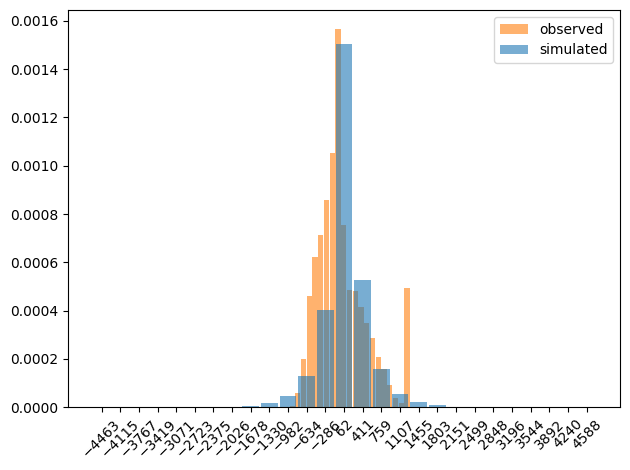

In [ ]:


az.plot_dist(
    df_all_predictors["TiltCurrent"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["current"],
    kind="hist",
    hist_kwargs={"alpha": 0.6},
    label="simulated",
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
with tilit_current_model:
    mean_field = pm.fit(
        method="advi", callbacks=[pm.callbacks.CheckParametersConvergence()]
    )

Output()

Interrupted at 3,024 [30%]: Average Loss = 3.7946e+06


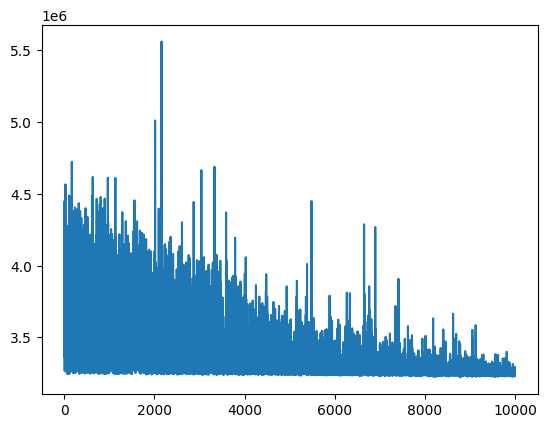

In [ ]:
plt.plot(mean_field.hist)

# MotionFeature models and Gaussian Process

In [1]:
import pytensor.tensor as pt
import pymc as pm
import numpy as np
from scipy.signal import savgol_filter

def MotionFeatureModel(data, window_size=5, poly_order=2, sigma_prior=1):
    """
    A model that incorporates motion features derived from gyro and accelerometer data
    along with position and distance information.
    
    Parameters:
    -----------
    data : DataFrame
        Contains columns: Position, DistanceToGoal, 
        Gyro_X, Gyro_Y, Gyro_Z, Accel_X, Accel_Y, Accel_Z
    window_size : int
        Window size for feature extraction
    poly_order : int
        Polynomial order for smoothing
    """
    # Prepare features
    motion_features = {}
    
    # 1. Smooth signals and calculate derivatives
    for sensor in ['Gyro', 'Accel']:
        for axis in ['X', 'Y', 'Z']:
            col = f"{sensor}_{axis}"
            # Smooth the signal
            motion_features[f"{col}_smooth"] = savgol_filter(
                data[col], window_size, poly_order
            )
            # Calculate rate of change
            motion_features[f"{col}_delta"] = np.gradient(
                motion_features[f"{col}_smooth"]
            )
    
    # 2. Calculate magnitude features
    motion_features['Gyro_Magnitude'] = np.sqrt(
        data['Gyro_X']**2 + data['Gyro_Y']**2 + data['Gyro_Z']**2
    )
    motion_features['Accel_Magnitude'] = np.sqrt(
        data['Accel_X']**2 + data['Accel_Y']**2 + data['Accel_Z']**2
    )
    
    # 3. Create rolling statistics
    for col in motion_features:
        series = pd.Series(motion_features[col])
        motion_features[f"{col}_roll_mean"] = series.rolling(window_size).mean()
        motion_features[f"{col}_roll_std"] = series.rolling(window_size).std()
    
    # Convert features to design matrix
    feature_names = list(motion_features.keys()) + ['Position', 'DistanceToGoal']
    X_matrix = np.column_stack([
        *motion_features.values(),
        data['Position'],
        data['DistanceToGoal']
    ])
    
    # Fill NaN values from rolling calculations
    X_matrix = np.nan_to_fill(X_matrix, 0)
    
    y = data['AvgCurrent']
    
    with pm.Model(coords={"features": feature_names}) as model:
        # Create shared variables
        X_shared = pm.Data("X_matrix", X_matrix)
        observed = pm.Data("AvgCurrent", y, dims="obs_id")
        
        # Hierarchical priors for feature groups
        sigma_groups = {
            'motion': pm.HalfNormal('sigma_motion', 1),
            'position': pm.HalfNormal('sigma_position', 1)
        }
        
        # Group-specific coefficients
        betas = {}
        n_motion = len(motion_features)
        
        # Motion features coefficients
        betas['motion'] = pm.Normal('betas_motion', 
                                  mu=0,
                                  sigma=sigma_groups['motion'],
                                  dims='motion_features',
                                  shape=n_motion)
        
        # Position features coefficients
        betas['position'] = pm.Normal('betas_position',
                                    mu=0,
                                    sigma=sigma_groups['position'],
                                    dims='position_features',
                                    shape=2)  # Position and DistanceToGoal
        
        # Combine all betas
        all_betas = pt.concatenate([betas['motion'], betas['position']])
        
        # Model parameters
        intercept = pm.Normal("intercept", 0, 10)
        sigma = pm.HalfNormal("sigma", sigma_prior)
        
        # Calculate mean
        mu = intercept + pt.dot(X_shared, all_betas)
        
        # Define likelihood with robust Student's t distribution
        likelihood = pm.StudentT("likelihood", 
                               nu=4,  # degrees of freedom
                               mu=mu,
                               sigma=sigma,
                               observed=observed)
        
        return model

def GaussianProcessModel(data, sigma_prior=1):
    """
    A Gaussian Process model that captures complex nonlinear relationships
    and temporal dependencies in the motion data.
    """
    # Prepare input features
    X = np.column_stack([
        data[['Position', 'DistanceToGoal']],
        data[['Gyro_X', 'Gyro_Y', 'Gyro_Z']],
        data[['Accel_X', 'Accel_Y', 'Accel_Z']]
    ])
    y = data['AvgCurrent']
    
    with pm.Model() as model:
        # Length scales for different feature groups
        ls_position = pm.HalfNormal("ls_position", 1)
        ls_gyro = pm.HalfNormal("ls_gyro", 1)
        ls_accel = pm.HalfNormal("ls_accel", 1)
        
        # Combine length scales
        ls = pt.concatenate([
            pt.ones(2) * ls_position,
            pt.ones(3) * ls_gyro,
            pt.ones(3) * ls_accel
        ])
        
        # Kernel amplitude
        eta = pm.HalfNormal("eta", 1)
        
        # Define the GP kernel
        cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=8, ls=ls)
        
        # Create GP
        gp = pm.gp.Marginal(cov_func=cov_func)
        
        # Add observation noise
        sigma = pm.HalfNormal("sigma", sigma_prior)
        
        # Place GP prior over data
        gp.marginal_likelihood("likelihood", X=X, y=y, noise=sigma)
        
        return model